In [144]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
import lightgbm as lgb

In [2]:
weather = pd.read_csv('data/weather_v2.csv')
target = pd.read_csv('data/target_v2.csv')

C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 데이터 설명

- prec : 강수량
- ws : 풍속
- wd : 풍향
- humid : 습도
- vaporP : 증기압
- dew : 이슬점 온도
- landP : 현지 기압
- seaP : 해면 기압
- suntime : 일조
- rad : 일사
- snow : 적설
- weathernumber : 현상번호
- sfctemp : 지면 온도

# 2. 모델 구축 시 사용할 지점 및 기상 속성 선정 과정

## 사용 지점 (4곳)
- 제주, 고산, 성산, 서귀포 (ASOS 지점)

## 선정 이유
- 전국적으로 ASOS에서 관측한 기온이 공식으로 인정 받기 때문에 ASOS 기온만 사용해볼 것이다.
출처: https://www.hankyung.com/society/article/201807242843Y

- 사용 기상 속성
    - 제주: 기온
    - 고산: 기온
    - 성산: 기온
    - 서귀포: 기온

## 선정 이유
- 기온은 결측값이 가장 적음과 동시에, smp 및 supply와의 상관관계도 기타 속성에 비해 강한 편이다

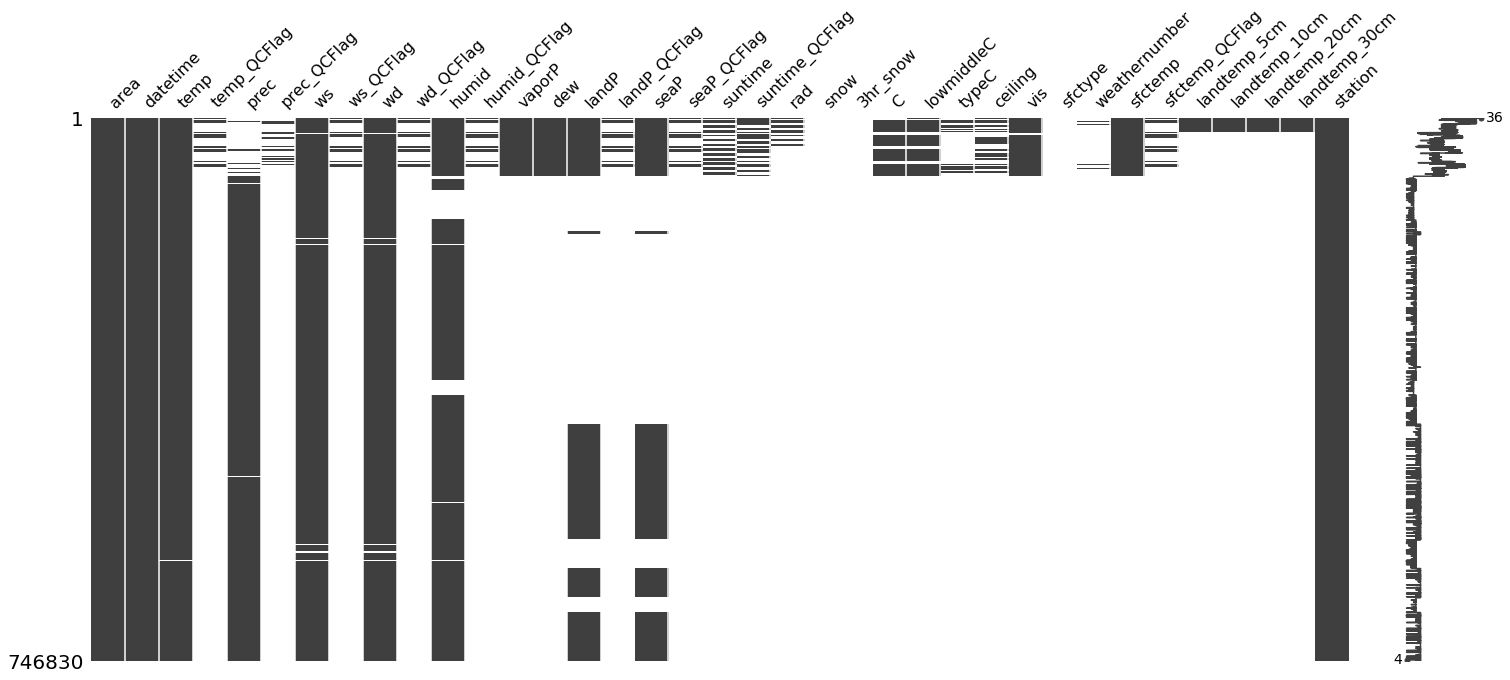

In [3]:
# 결측치 확인
import missingno as msno
msno.matrix(weather)

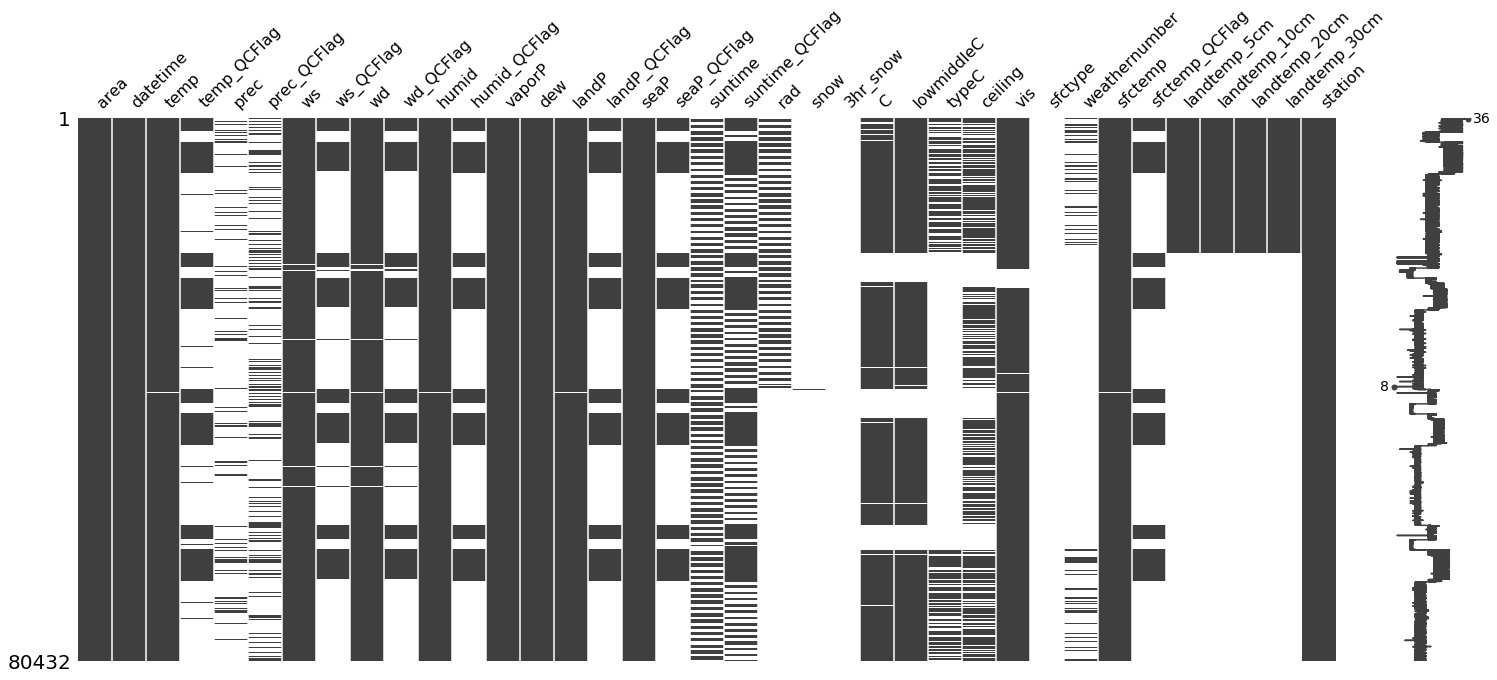

In [4]:
msno.matrix(weather[weather['station'] == "ASOS"])

In [5]:
weather['date'] = weather['datetime'].apply(lambda x : x[:10])
weather_mean = weather.groupby('date').mean().reset_index(drop = True)

In [6]:
# 평균 상관관계 확인 
pd.concat([target, weather_mean], axis = 1).corr().loc['smp_max':'supply','area':].abs().mean().sort_values(ascending = False).head(10)

landtemp_30cm    0.323563
landtemp_5cm     0.300492
landtemp_20cm    0.293111
landtemp_10cm    0.292360
temp             0.291700
sfctemp          0.283049
dew              0.269303
vaporP           0.246189
landP            0.223619
seaP             0.182458
dtype: float64

# 3. 데이터 전처리
## target
- target의 date에서 년, 월, 일, 요일을 찾아 추가


## weather
- ASOS 지역의 기온만을 사용
- 기온는 지역별 기온의 중앙값만을 사용
- 선정된 시간별 기온에서 그 날의 최소기온, 최고기온, 평균기온를 찾아 target에 추가

In [7]:
target['date'] = pd.to_datetime(target['date'])

target['year'] = target['date'].dt.year
target['month'] = target['date'].dt.month
target['day'] = target['date'].dt.day
target['dayofweek'] = target['date'].dt.dayofweek

In [8]:
target.head()

date  smp_max  smp_min  smp_mean  supply  year  month  day  dayofweek
0 2018-02-01   150.65   116.84    132.71   87.47  2018      2    1          3
1 2018-02-02   163.86   116.84    134.19   86.64  2018      2    2          4
2 2018-02-03   164.07   116.85    131.39   88.28  2018      2    3          5
3 2018-02-04   171.00   115.76    131.89   86.14  2018      2    4          6
4 2018-02-05   170.34   123.89    137.96   90.63  2018      2    5          0

In [9]:
weather = weather[weather['station'] == 'ASOS']

In [10]:
columns = ['area', 'datetime', 'temp', 'ws', 'wd', 'humid', 'landP', 'seaP', 'sfctemp']

In [11]:
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather = weather.loc[:,columns]

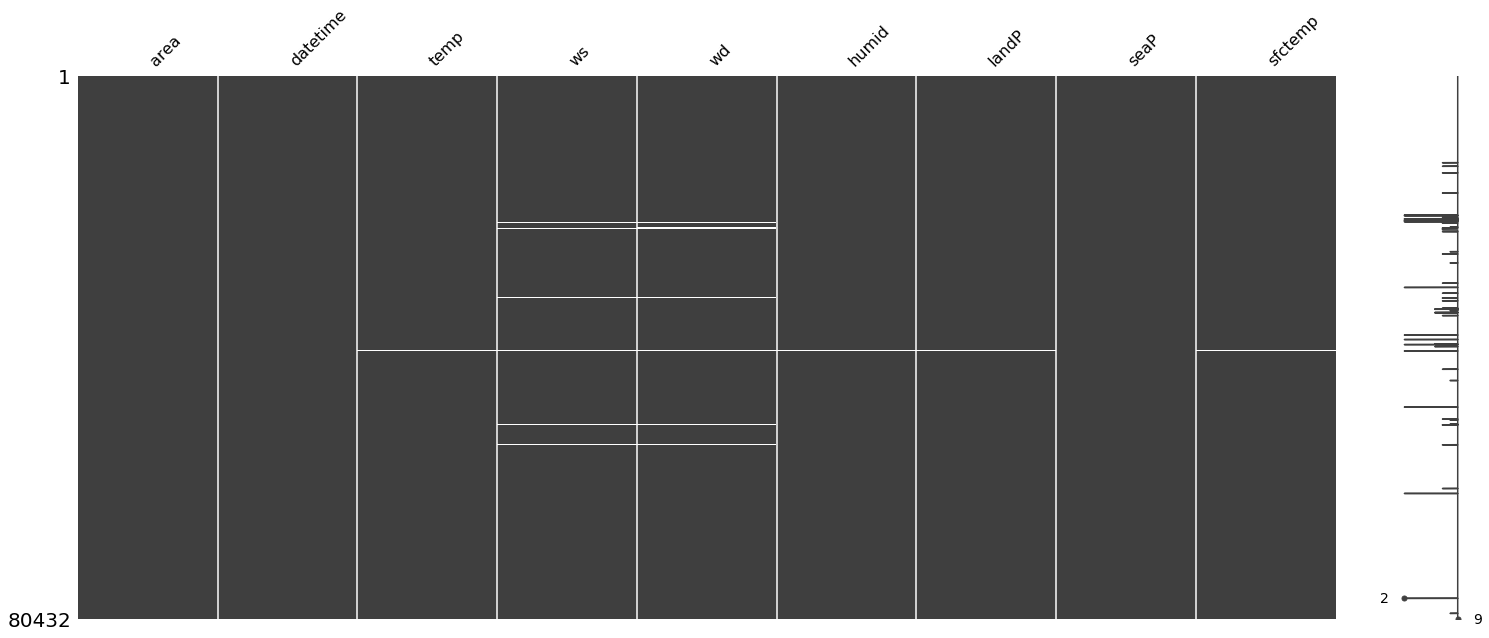

In [12]:
msno.matrix(weather)

In [13]:
cols = weather.columns[2:]

In [14]:
weather_list = []
for area in weather['area'].unique():
    weather_list.append(weather[weather['area']==area].copy())
    
for i, area in enumerate(weather['area'].unique()):
    weather_list[i].drop(['area'], axis=1, inplace=True)
    weather_list[i].columns = ['datetime'] + [f"{area}_{col}" for col in cols]

In [15]:
areas = [184, 185, 188, 189]

In [16]:
start = '2018-02-01'
end = '2020-05-18'
hourly_temperature = pd.DataFrame(columns = ['datetime'])
date_range = pd.date_range(start, end, freq='H')
hourly_temperature['datetime'] = date_range

for d in weather_list:
    hourly_temperature  = hourly_temperature.merge(d, how='outer')

for col in cols:
    hourly_temperature[f'{col}_median'] = hourly_temperature[[f"{area}_{col}" for area in areas]].median(axis=1)

hourly_temperature = hourly_temperature.loc[:,['datetime'] + [f"{col}_median" for col in cols]]
hourly_temperature.columns = ['date', 'temperature', 'wind speed', 'wind direction', \
                              'humid', 'land pressure', 'sea pressure', \
                              'ground temperature']

# 결측치
- index : 0, 8760

In [42]:
for i in [0]:
    for col in hourly_temperature.columns[1:]:
        hourly_temperature.loc[i, col] = hourly_temperature.loc[i+1][col] * 2 - hourly_temperature.loc[i+2][col]

hourly_temperature.loc[0, 'wind direction'] = 0

for i in [8760]:
    for col in hourly_temperature.columns[1:]:
        hourly_temperature.loc[i, col] = (hourly_temperature.loc[i - 1][col] + hourly_temperature.loc[i+1][col]) / 2

In [44]:
hourly_temperature.isnull().sum()

date                  0
temperature           0
wind speed            0
wind direction        0
humid                 0
land pressure         0
sea pressure          0
ground temperature    0
dtype: int64

In [13]:
# 결측치는 1시간 후 온도로 처리
# hourly_temperature['temperature'][hourly_temperature['temperature'].isna()] = hourly_temperature.shift(-1)['temperature'][hourly_temperature['temperature'].isna()]

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


-------------------------------------------------------------------------------------------------------------------------------

In [50]:
start = '2018-02-01'
end = '2020-05-18'
daily_temperature = pd.DataFrame(columns = ['date'])
date_range = pd.date_range(start, end, freq='D')
daily_temperature['date'] = date_range

In [51]:
for d in range(daily_temperature.shape[0]):
    for h in range(24):
        daily_temperature.loc[d, 'temperature_h'+str(h)] = hourly_temperature['temperature'][d*24:d*24+24][d*24+h]
        daily_temperature.loc[d, 'wind speed_h'+str(h)] = hourly_temperature['wind speed'][d*24:d*24+24][d*24+h]
        daily_temperature.loc[d, 'wind direction_h'+str(h)] = hourly_temperature['wind direction'][d*24:d*24+24][d*24+h]
        daily_temperature.loc[d, 'humid_h'+str(h)] = hourly_temperature['humid'][d*24:d*24+24][d*24+h]
        daily_temperature.loc[d, 'land pressure_h'+str(h)] = hourly_temperature['land pressure'][d*24:d*24+24][d*24+h]
        daily_temperature.loc[d, 'sea pressure_h'+str(h)] = hourly_temperature['sea pressure'][d*24:d*24+24][d*24+h]
        daily_temperature.loc[d, 'ground temperature_h'+str(h)] = hourly_temperature['ground temperature'][d*24:d*24+24][d*24+h]

In [52]:
for col in hourly_temperature.columns[1:]:
    
    cols = [f"{col}_h{i}" for i in range(24)]

    daily_temperature[f'{col}_max'] = daily_temperature.loc[:, cols].max(axis=1)
    daily_temperature[f'{col}_min'] = daily_temperature.loc[:, cols].min(axis=1)
    daily_temperature[f'{col}_mean'] = daily_temperature.loc[:, cols].mean(axis=1)

In [55]:
hourly_temperature.columns[1:]

Index(['temperature', 'wind speed', 'wind direction', 'humid', 'land pressure',
       'sea pressure', 'ground temperature'],
      dtype='object')

In [53]:
daily_temperature.head()

date  temperature_h0  wind speed_h0  wind direction_h0  humid_h0  \
0 2018-02-01            3.65           3.35                0.0      62.5   
1 2018-02-02            3.20           3.20              350.0      58.0   
2 2018-02-03            3.90           2.10              320.0      51.0   
3 2018-02-04           -0.65           5.75              330.0      64.5   
4 2018-02-05           -0.95           4.60              330.0      76.0   

   land pressure_h0  sea pressure_h0  ground temperature_h0  temperature_h1  \
0           1021.80          1026.60                   2.50            3.80   
1           1023.30          1028.40                   1.35            2.85   
2           1022.20          1027.25                   1.15            4.00   
3           1023.60          1027.90                   0.15           -1.20   
4           1023.65          1028.00                   0.35           -1.70   

   wind speed_h1  ...  humid_mean  land pressure_max  land pressure_min  \
0           2.70  ...   58.687500            1023.50             1020.8   
1           3.30  ...   55.312500            1023.30             1020.9   
2           3.05  ...   67.291667            1024.05             1021.7   
3           5.95  ...   72.083333            1024.05             1022.2   
4           3.45  ...   71.458333            1024.10             1019.8   

   land pressure_mean  sea pressure_max  sea pressure_min  sea pressure_mean  \
0         1021.827083           1028.65           1025.65        1026.722917   
1         1022.212500           1028.55           1026.15        1027.408333   
2         1022.839583           1028.60           1026.05        1027.387500   
3         1023.377083           1028.35           1026.65        1027.793750   
4         1022.018750           1028.40           1024.15        1026.366667   

   ground temperature_max  ground temperature_min  ground temperature_mean  
0                   13.45                    1.45                 4.293750  
1                   13.70                    0.85                 4.072917  
2                    4.25                    0.55                 2.060417  
3                    3.80                    0.15                 1.150000  
4                    4.85                    0.25                 1.502083  

[5 rows x 190 columns]

In [56]:
cols = ['temp', 'ws', 'wd', 'humid', 'landP', 'seaP', 'sfctemp']

In [57]:
for col1, col2 in zip(cols, hourly_temperature.columns[1:]):
    target[f'{col1}_max'] = daily_temperature[f'{col2}_max']
    target[f'{col1}_min'] = daily_temperature[f'{col2}_min']
    target[f'{col1}_mean'] = daily_temperature[f'{col2}_mean']

In [58]:
target.tail()

date  smp_max  smp_min  smp_mean  supply  year  month  day  \
833 2020-05-14   193.28    66.78    100.46   62.70  2020      5   14   
834 2020-05-15   198.23    61.81    102.38   64.91  2020      5   15   
835 2020-05-16   220.91    88.50    121.19   61.75  2020      5   16   
836 2020-05-17   207.75    65.78    116.82   61.55  2020      5   17   
837 2020-05-18   113.31    66.86     98.98   63.91  2020      5   18   

     dayofweek  temp_max  ...  humid_mean  landP_max  landP_min   landP_mean  \
833          3     22.35  ...   57.541667    1015.00    1009.25  1012.525000   
834          4     21.50  ...   95.083333    1009.35    1002.45  1004.537500   
835          5     19.05  ...   97.562500    1004.40    1001.00  1002.822917   
836          6     20.35  ...   91.375000    1003.35    1000.80  1002.068750   
837          0     22.45  ...   94.125000    1000.55     993.25   996.272917   

     seaP_max  seaP_min    seaP_mean  sfctemp_max  sfctemp_min  sfctemp_mean  
833   1019.30   1013.35  1016.764583        31.90        11.90     20.660417  
834   1013.20   1006.75  1008.741667        24.85        18.60     20.304167  
835   1008.80   1005.50  1007.195833        24.40        17.60     20.197917  
836   1007.50   1004.90  1006.322917        31.35        15.90     21.227083  
837   1004.75    997.95  1000.766667        26.85        14.05     20.472917  

[5 rows x 30 columns]

# 4. 탐색적 자료분석

In [66]:
display(target.head(8))
print(target.shape)

date  smp_max  smp_min  smp_mean  supply  year  month  day  dayofweek  \
0 2018-02-01   150.65   116.84    132.71   87.47  2018      2    1          3   
1 2018-02-02   163.86   116.84    134.19   86.64  2018      2    2          4   
2 2018-02-03   164.07   116.85    131.39   88.28  2018      2    3          5   
3 2018-02-04   171.00   115.76    131.89   86.14  2018      2    4          6   
4 2018-02-05   170.34   123.89    137.96   90.63  2018      2    5          0   
5 2018-02-06   167.99   119.11    140.06   91.18  2018      2    6          1   
6 2018-02-07   141.07   124.11    132.76   90.09  2018      2    7          2   
7 2018-02-08   147.42   116.84    132.91   87.57  2018      2    8          3   

   temp_max  ...  humid_mean  landP_max  landP_min   landP_mean  seaP_max  \
0      5.95  ...   58.687500    1023.50     1020.8  1021.827083   1028.65   
1      5.25  ...   55.312500    1023.30     1020.9  1022.212500   1028.55   
2      4.00  ...   67.291667    1024.05     1021.7  1022.839583   1028.60   
3      0.30  ...   72.083333    1024.05     1022.2  1023.377083   1028.35   
4      2.05  ...   71.458333    1024.10     1019.8  1022.018750   1028.40   
5     -0.20  ...   73.437500    1022.10     1019.4  1020.562500   1026.80   
6      2.30  ...   73.395833    1022.30     1019.9  1020.972917   1026.90   
7      6.10  ...   78.083333    1020.30     1016.2  1018.431250   1024.20   

   seaP_min    seaP_mean  sfctemp_max  sfctemp_min  sfctemp_mean  
0   1025.65  1026.722917        13.45         1.45      4.293750  
1   1026.15  1027.408333        13.70         0.85      4.072917  
2   1026.05  1027.387500         4.25         0.55      2.060417  
3   1026.65  1027.793750         3.80         0.15      1.150000  
4   1024.15  1026.366667         4.85         0.25      1.502083  
5   1024.05  1025.079167         3.60        -0.50      0.600000  
6   1024.50  1025.556250         7.35        -0.45      1.481250  
7   1021.70  1022.862500        10.05        -0.40      2.014583  

[8 rows x 30 columns]

(838, 30)


In [70]:
target[['supply'] + [col for col in target.columns if 'mean' in col]].corr()

supply  smp_mean  temp_mean   ws_mean   wd_mean  humid_mean  \
supply        1.000000  0.002999  -0.230330  0.150160  0.259816   -0.132141   
smp_mean      0.002999  1.000000   0.423769 -0.100032 -0.253034    0.134277   
temp_mean    -0.230330  0.423769   1.000000 -0.177068 -0.410524    0.588003   
ws_mean       0.150160 -0.100032  -0.177068  1.000000  0.188209   -0.044247   
wd_mean       0.259816 -0.253034  -0.410524  0.188209  1.000000   -0.393967   
humid_mean   -0.132141  0.134277   0.588003 -0.044247 -0.393967    1.000000   
landP_mean    0.188617 -0.192327  -0.769895 -0.090813  0.258601   -0.640829   
seaP_mean     0.197962 -0.199256  -0.786413 -0.073780  0.275670   -0.649013   
sfctemp_mean -0.187479  0.398688   0.975528 -0.209715 -0.374373    0.531822   

              landP_mean  seaP_mean  sfctemp_mean  
supply          0.188617   0.197962     -0.187479  
smp_mean       -0.192327  -0.199256      0.398688  
temp_mean      -0.769895  -0.786413      0.975528  
ws_mean        -0.090813  -0.073780     -0.209715  
wd_mean         0.258601   0.275670     -0.374373  
humid_mean     -0.640829  -0.649013      0.531822  
landP_mean      1.000000   0.999054     -0.762394  
seaP_mean       0.999054   1.000000     -0.778065  
sfctemp_mean   -0.762394  -0.778065      1.000000

C:\Users\user\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


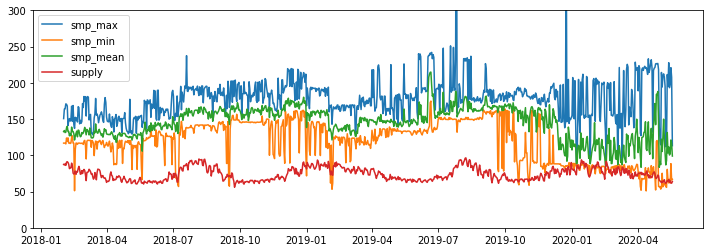

In [60]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.plot(target.loc[:, 'date'], target.loc[:, 'smp_max'], label='smp_max')
plt.plot(target.loc[:, 'date'], target.loc[:, 'smp_min'], label='smp_min')
plt.plot(target.loc[:, 'date'], target.loc[:, 'smp_mean'], label='smp_mean')
plt.plot(target.loc[:, 'date'], target.loc[:, 'supply'], label='supply')
plt.ylim(0,300)
plt.legend()
plt.show()

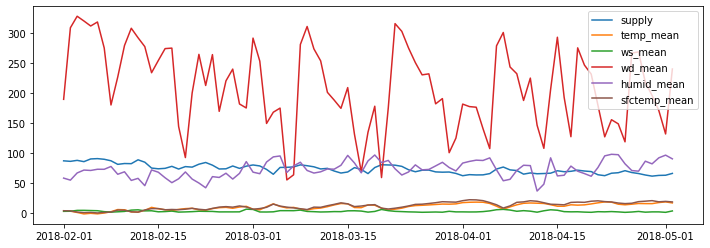

In [82]:
plt.rcParams['figure.figsize'] = [12, 4]
count = 90
plt.plot(target.loc[:count, 'date'], target.loc[:count, 'supply'], label='supply')
for col in cols:
    if 'seaP' not in col and 'landP' not in col:
        plt.plot(target.loc[:count, 'date'], target.loc[:count, f'{col}_mean'], label=f'{col}_mean')
plt.legend()
plt.show()

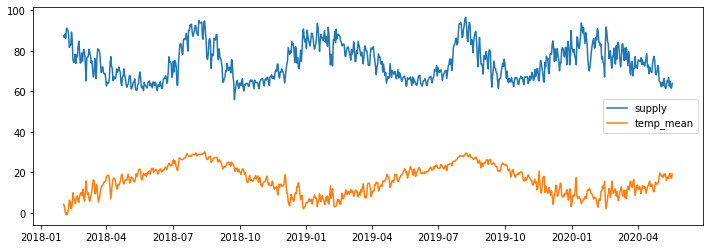

In [61]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.plot(target.loc[:, 'date'], target.loc[:, 'supply'], label='supply')
plt.plot(target.loc[:, 'date'], target.loc[:, 'temp_mean'], label='temp_mean')
plt.legend()
plt.show()

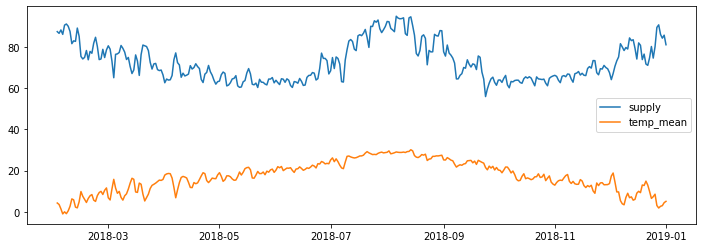

In [25]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.plot(target.loc[:334, 'date'], target.loc[:334, 'supply'], label='supply')
plt.plot(target.loc[:334, 'date'], target.loc[:334, 'temp_mean'], label='temp_mean')
plt.legend()
plt.show()

### temp와 supply는 상관 관계를 갖는다
- (2차원)

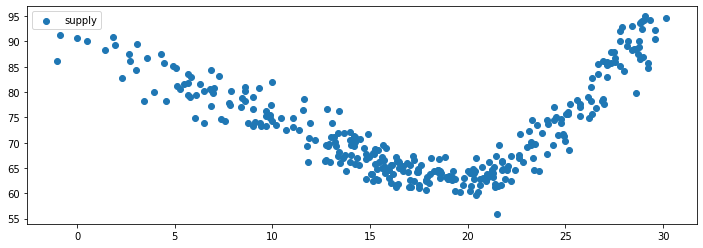

In [26]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.scatter(target.loc[:334, 'temp_mean'], target.loc[:334, 'supply'], label='supply')
plt.legend()
plt.show()

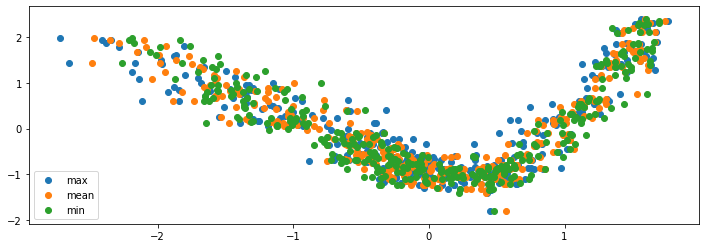

In [43]:
temp_max_scaler = StandardScaler().fit_transform(target.loc[:334, ['temp_max', 'supply']])
temp_mean_scaler = StandardScaler().fit_transform(target.loc[:334, ['temp_mean', 'supply']])
temp_min_scaler = StandardScaler().fit_transform(target.loc[:334, ['temp_min', 'supply']])

plt.rcParams['figure.figsize'] = [12, 4]
plt.scatter(temp_max_scaler[:, 0], temp_mean_scaler[:, 1], label='max')
plt.scatter(temp_mean_scaler[:, 0], temp_mean_scaler[:, 1], label='mean')
plt.scatter(temp_min_scaler[:, 0], temp_mean_scaler[:, 1], label='min')
plt.legend()
plt.show()

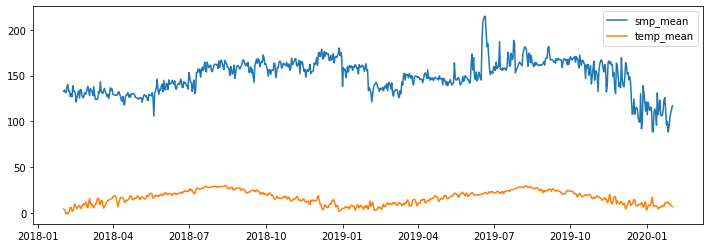

In [22]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.plot(target.loc[:, 'date'], target.loc[:, 'smp_mean'], label='smp_mean')
plt.plot(target.loc[:, 'date'], target.loc[:, 'temp_mean'], label='temp_mean')
plt.legend()
plt.show()

### SMP와 temp, supply
- 연관 관계가 없는 것 같다.

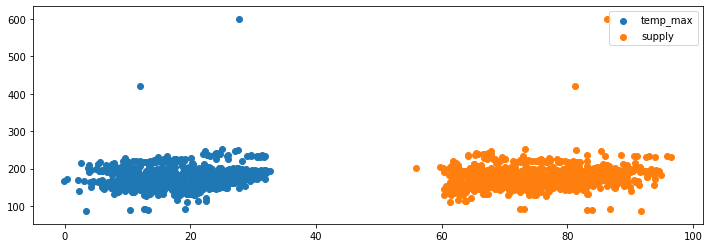

In [65]:
plt.rcParams['figure.figsize'] = [12, 4]
plt.scatter(target.loc[:, 'temp_max'], target.loc[:, 'smp_max'], label='temp_max')
plt.scatter(target.loc[:, 'supply'], target.loc[:, 'smp_max'], label='supply')
plt.legend()
plt.show()

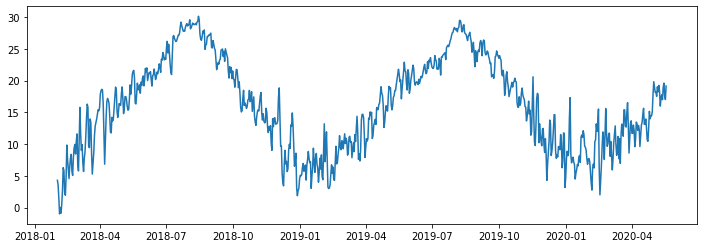

In [54]:
plt.plot(target.loc[:, 'date'], target.loc[:, 'temp_mean'], label='temp_mean')

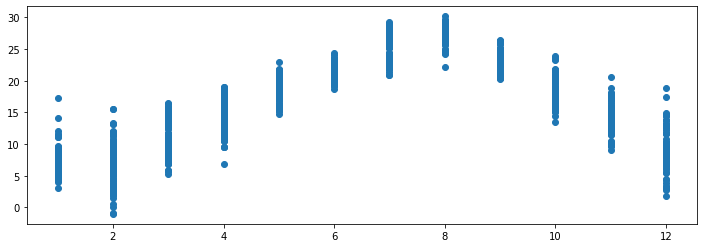

In [57]:
plt.scatter(target.loc[:, 'month'], target.loc[:, 'temp_mean'], label='temp_mean')

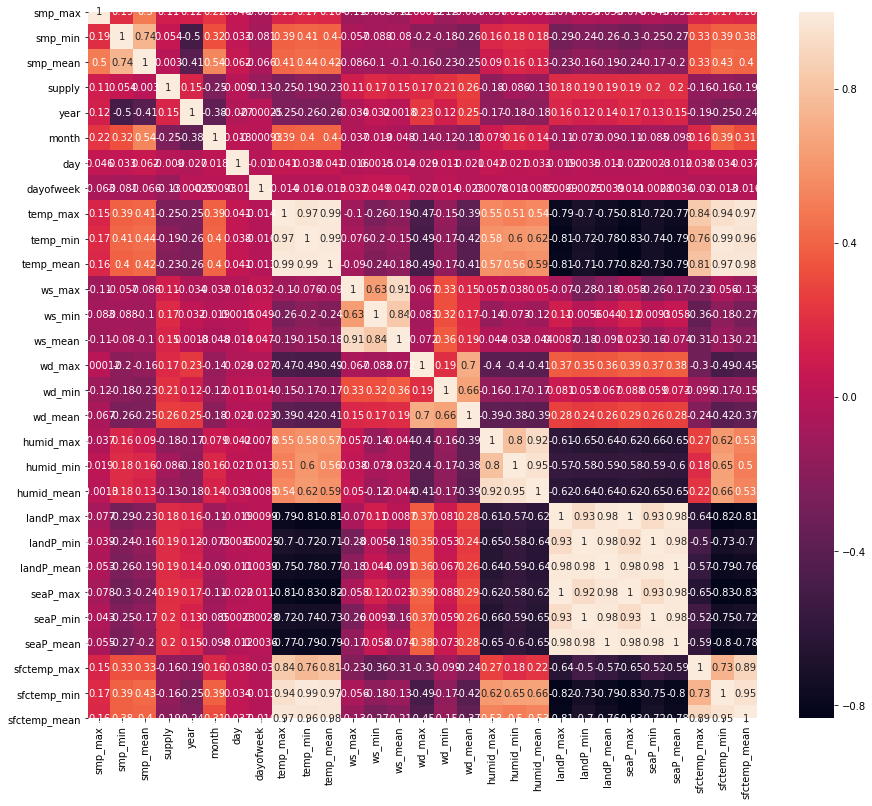

In [68]:
plt.rcParams['figure.figsize'] = [15, 13]
sns.heatmap(target.corr(), annot=True)

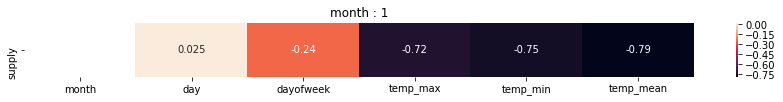

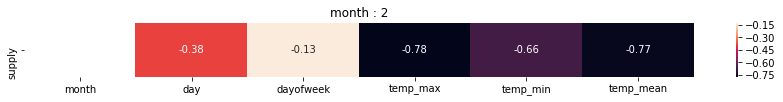

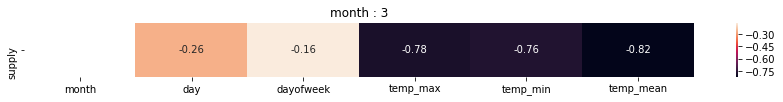

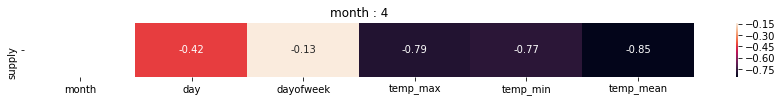

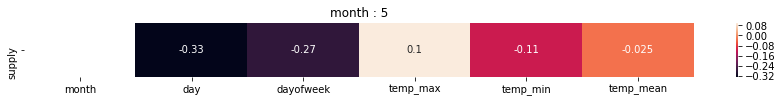

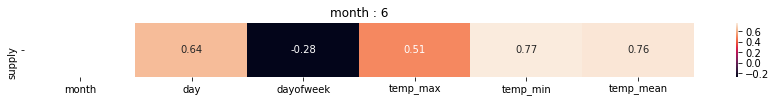

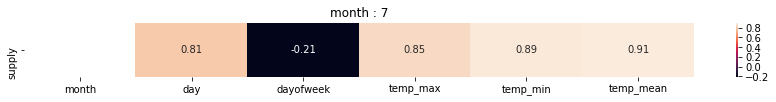

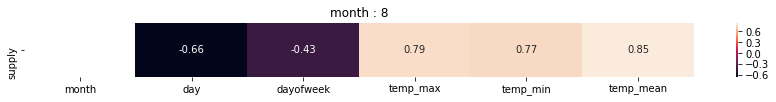

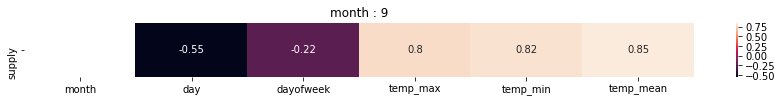

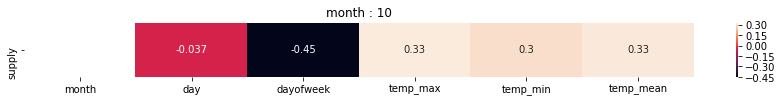

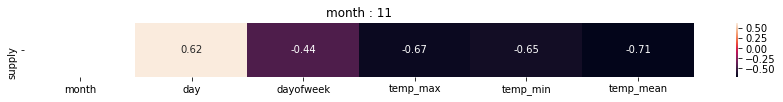

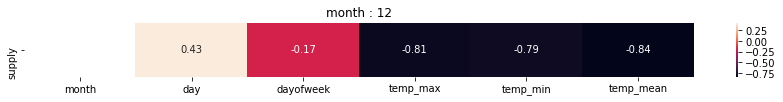

In [26]:
plt.rcParams['figure.figsize'] = [15, 1]
for m in range(1, 13):
    sns.heatmap(target[target['date'].dt.month == m].corr().loc[['supply'],['month', 'day', 'dayofweek', 'temp_max', 'temp_min', 'temp_mean']], annot=True)
    plt.title('month : '+ str(m))
    plt.show()

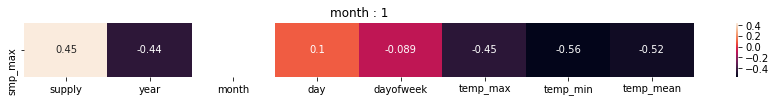

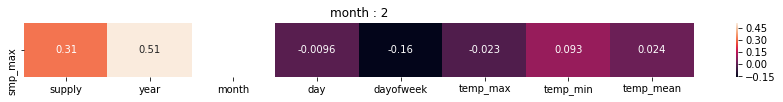

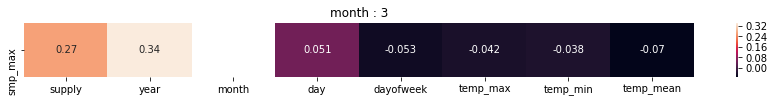

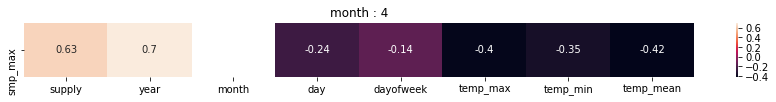

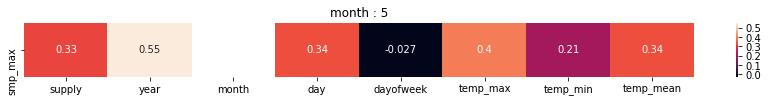

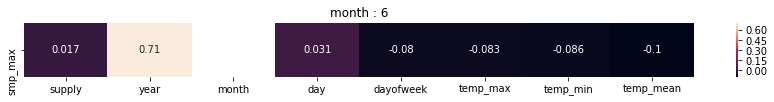

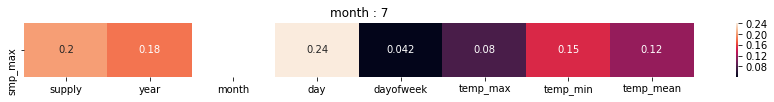

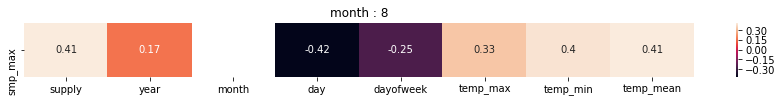

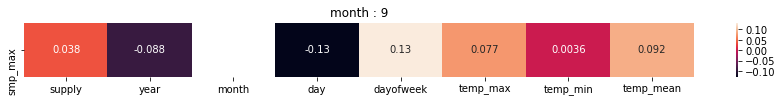

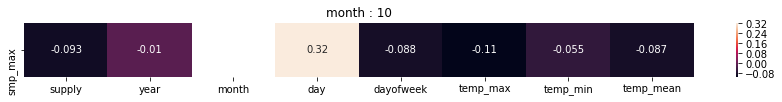

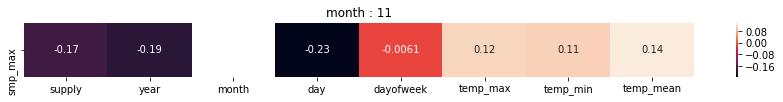

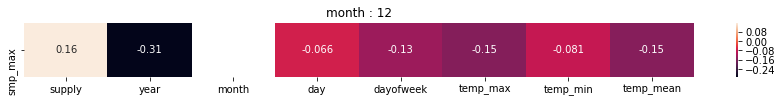

In [27]:
plt.rcParams['figure.figsize'] = [15, 1]
for m in range(1, 13):
    sns.heatmap(target[target['date'].dt.month == m].corr().loc[['smp_max'],'supply':], annot=True)
    plt.title('month : '+ str(m))
    plt.show()

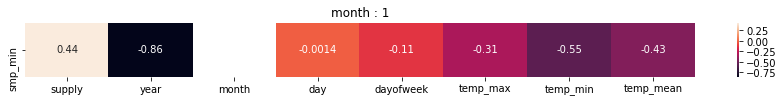

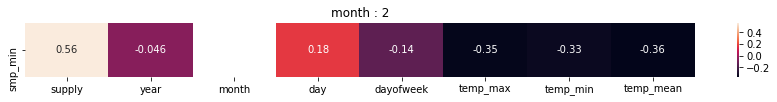

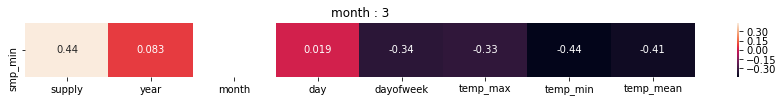

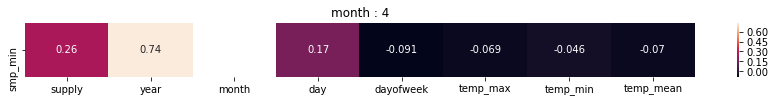

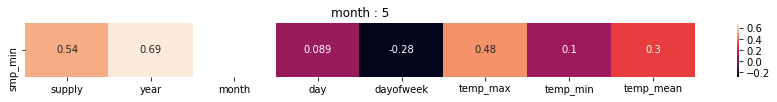

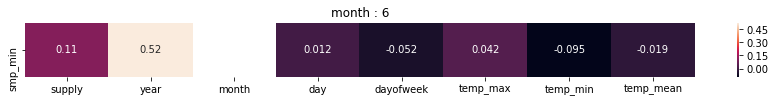

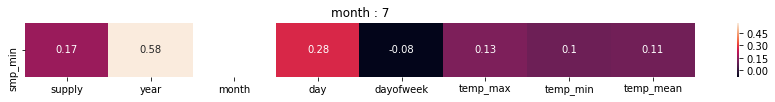

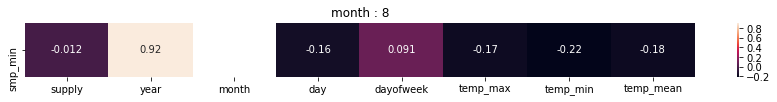

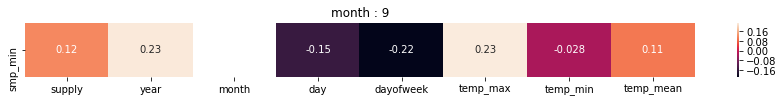

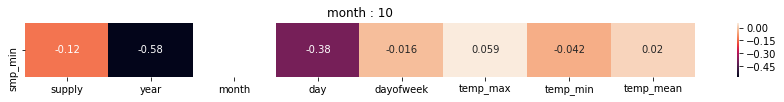

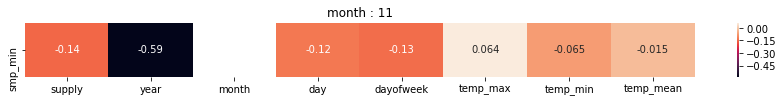

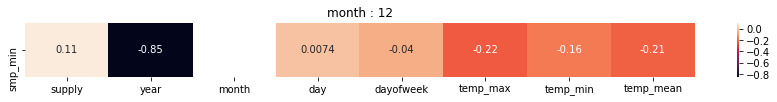

In [28]:
plt.rcParams['figure.figsize'] = [15, 1]
for m in range(1, 13):
    sns.heatmap(target[target['date'].dt.month == m].corr().loc[['smp_min'],'supply':], annot=True)
    plt.title('month : '+ str(m))
    plt.show()

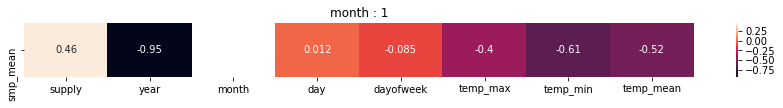

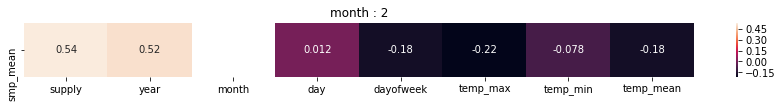

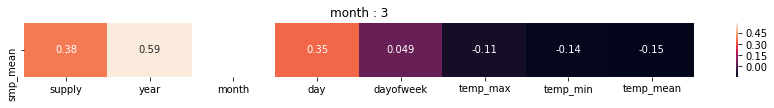

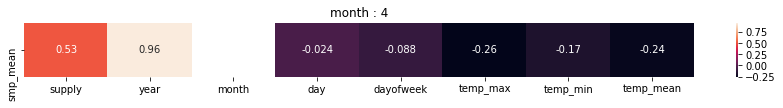

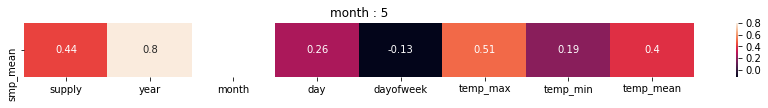

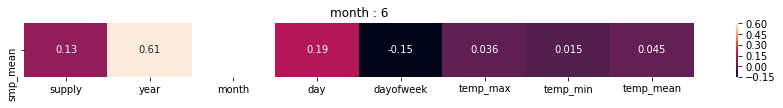

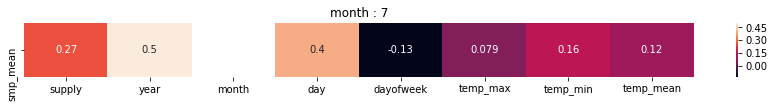

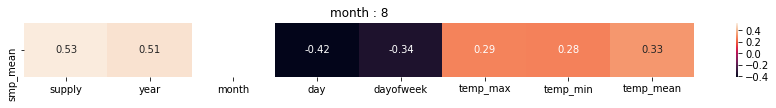

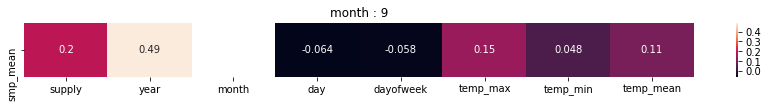

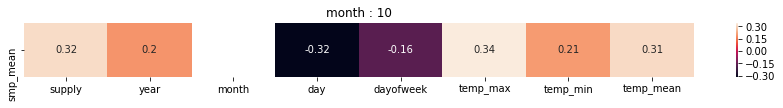

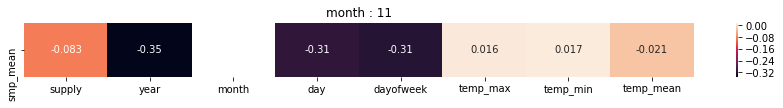

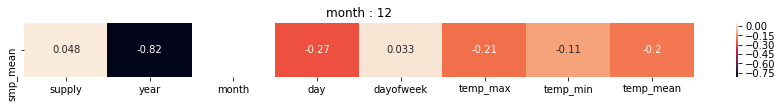

In [29]:
plt.rcParams['figure.figsize'] = [15, 1]
for m in range(1, 13):
    sns.heatmap(target[target['date'].dt.month == m].corr().loc[['smp_mean'],'supply':], annot=True)
    plt.title('month : '+ str(m))
    plt.show()

# 5. 모델 학습 및 검증
- lgbm을 이용하여 2가지 모델 작성

 
- 1) 과거 정보를 이용해 supply, 기상정보를 예측하는 모델 (시계열 모델)

- 2) supply, 기상정보를 이용하여 smp를 예측하는 모델 (상관관계 모델)

- 1)의 모델을 이용해 supply, 기상정보를 예측한 후 2)의 모델로 smp를 예측

In [98]:
past = 29 # 최근 30일 정보를 이용하여 n일 후를 예측

In [172]:
target['stand_temp_max'] = StandardScaler().fit_transform(target[['temp_max', 'supply']])[:, 0]
target['stand_temp_min'] = StandardScaler().fit_transform(target[['temp_mean', 'supply']])[:, 0]
target['stand_temp_mean'] = StandardScaler().fit_transform(target[['temp_min', 'supply']])[:, 0]

In [173]:
def trans(dataset, start_index, end_index, past, future, x_columns, y_columns):
    dataset.index = range(dataset.shape[0])
    data = []
    labels = []
    
    start_index = start_index + past
    
    if end_index is None:
        end_index = dataset.shape[0]
    
    for i in range(start_index, end_index-future):
        indices = np.array(dataset.loc[i-past:i, x_columns])
        data.append(indices)
        
        labels.append(np.array(dataset.loc[i+future, y_columns]))
        
    data = np.array(data)
    data = data.reshape(data.shape[0], -1)
    labels = np.array(labels)
    labels = labels.reshape(-1)
    
    return data, labels

In [181]:
def create_model(x_train, y_train, x_val, y_val):
#     params = {
#         'metric': 'mae',
#         'seed':7777
#         }
    
#     d_train = lgb.Dataset(x_train, y_train)
#     d_val = lgb.Dataset(x_val, y_val)

#     model = lgb.train(params, d_train, 1200, d_val, verbose_eval=100, early_stopping_rounds=200)

    model = Lasso()
    model.fit(x_train, y_train)

    return model

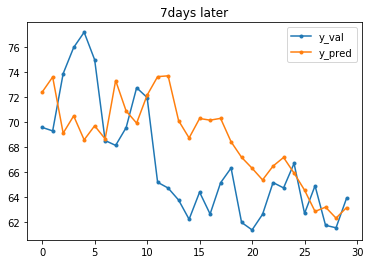

3.871922369285904


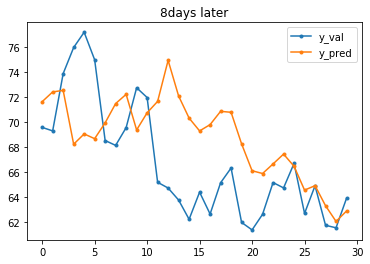

3.989942597639011


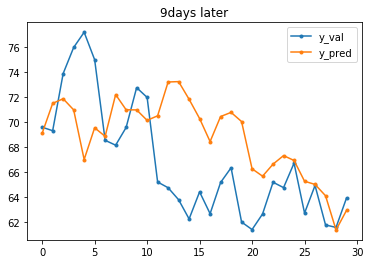

3.8436695263947893


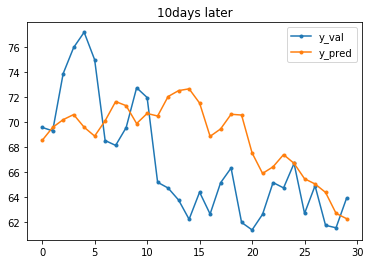

3.9692450716804926


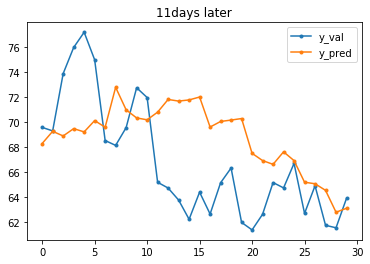

4.040366001350263


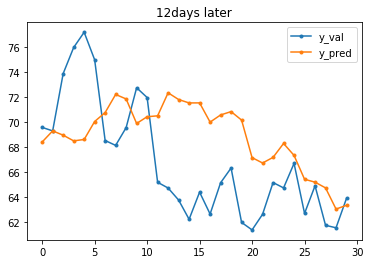

4.2374188096263365


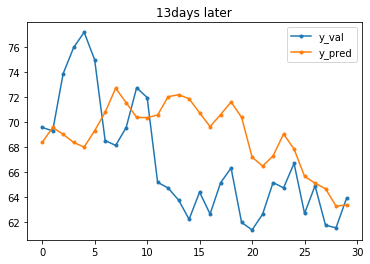

4.348604828470185


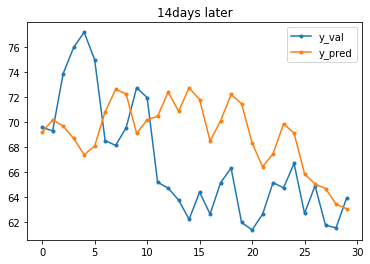

4.603398704881584


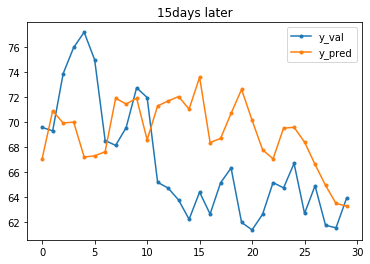

4.757424296894827


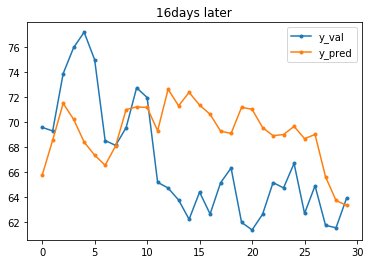

4.6643761585327725


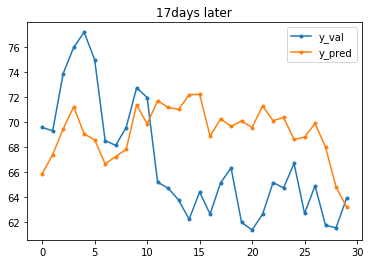

4.958617463311427


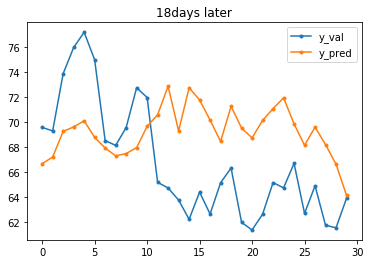

5.106107685366007


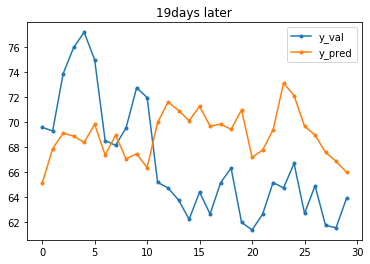

5.256306382439019


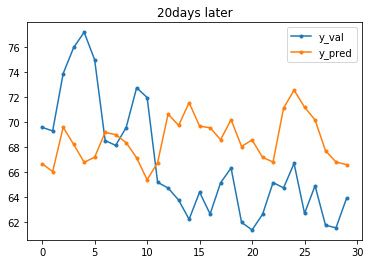

5.09850869225345


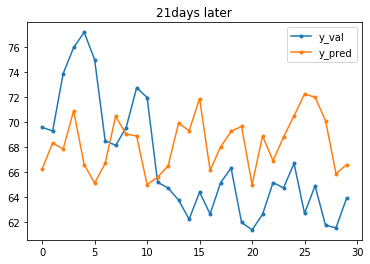

4.757066095895066


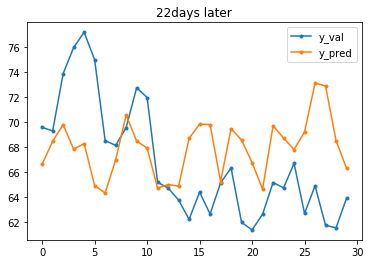

4.421754503305964


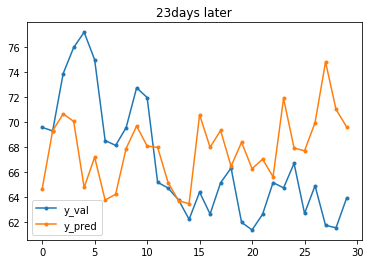

4.492760588121243


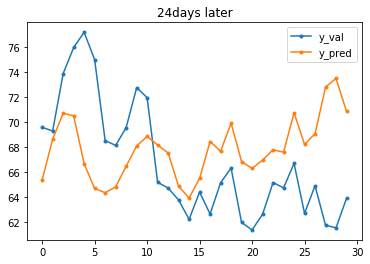

4.584045710485144


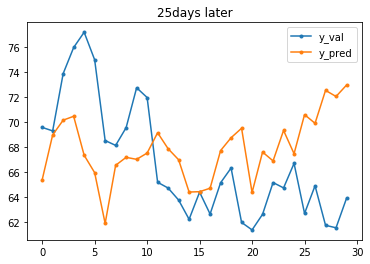

4.627757906919695


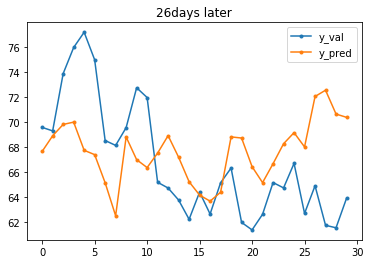

4.287504005232342


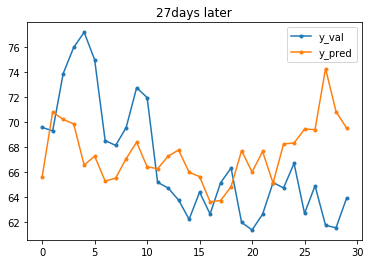

4.2534462476283785


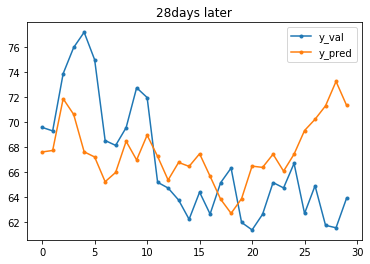

4.009586989560366


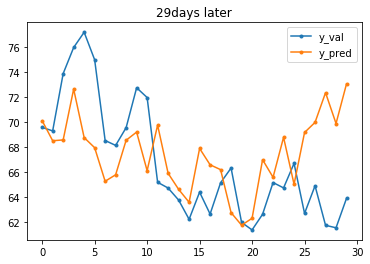

3.7578844896896104


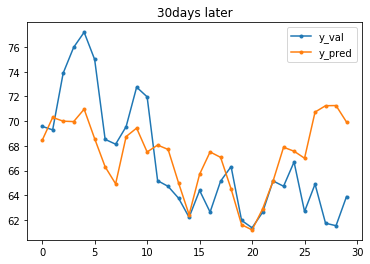

3.2007636141167564


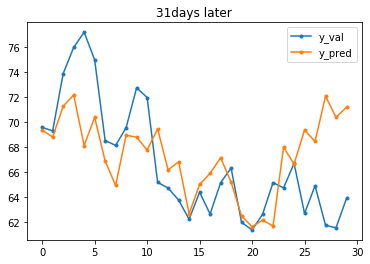

3.175397639154593


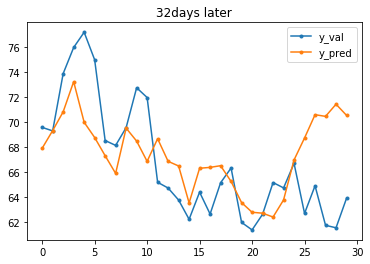

3.1846621599258005


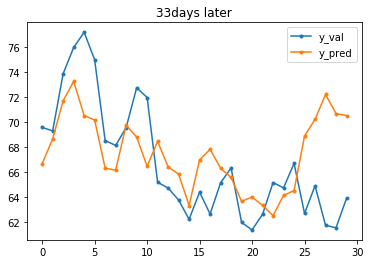

3.3240318595353937


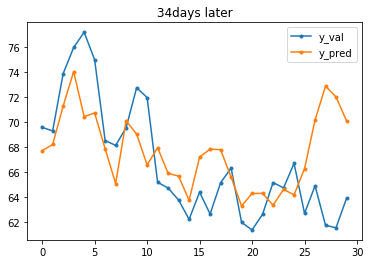

3.2525550949124513


In [182]:
x_columns = ['year', 'month', 'day', 'dayofweek', 'supply', \
             'stand_temp_max', 'stand_temp_min', 'stand_temp_mean', \
            'wd_mean', 'wd_mean', 'humid_mean', 'landP_mean', 'seaP_mean', 'sfctemp_mean']
y_columns = ['supply']
supply_models = {}
scores = []

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30 # 마지막 30일을 validation set으로 사용
    x_train, y_train = trans(target, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)

    supply_models[future] = create_model(x_train, y_train, x_val, y_val)
    
    pred = supply_models[future].predict(x_val)
    
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.plot(np.array(y_val), '.-', label='y_val')
    plt.plot(pred, '.-', label='y_pred')
    plt.title(str(future)+'days later')
    plt.legend()
    plt.show()
    
#     scores.append(dict(supply_models[future].best_score)['valid_0']['l1'])
    score = mean_absolute_error(y_val, pred)
    scores.append(score)
    
    print(score)
    print('==========================================================================')

In [184]:
mean_score = 0

for future, score in zip(range(7, 35), scores):
    print(f"{future:2} : {score}")
    
    mean_score += score
print("mean", mean_score / len(scores))

 7 : 3.871922369285904
 8 : 3.989942597639011
 9 : 3.8436695263947893
10 : 3.9692450716804926
11 : 4.040366001350263
12 : 4.2374188096263365
13 : 4.348604828470185
14 : 4.603398704881584
15 : 4.757424296894827
16 : 4.6643761585327725
17 : 4.958617463311427
18 : 5.106107685366007
19 : 5.256306382439019
20 : 5.09850869225345
21 : 4.757066095895066
22 : 4.421754503305964
23 : 4.492760588121243
24 : 4.584045710485144
25 : 4.627757906919695
26 : 4.287504005232342
27 : 4.2534462476283785
28 : 4.009586989560366
29 : 3.7578844896896104
30 : 3.2007636141167564
31 : 3.175397639154593
32 : 3.1846621599258005
33 : 3.3240318595353937
34 : 3.2525550949124513
mean 4.216968767593174


In [34]:
x_columns = ['year', 'month', 'day', 'temp_max', 'temp_min', 'temp_mean']

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[156]	valid_0's l1: 2.03905


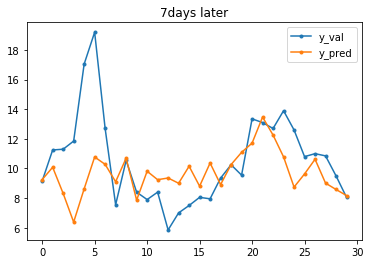

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[29]	valid_0's l1: 1.8484


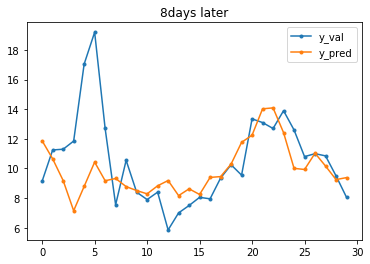

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's l1: 1.77739


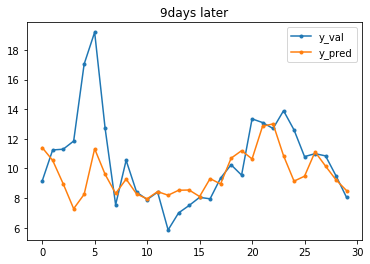

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[37]	valid_0's l1: 1.83476


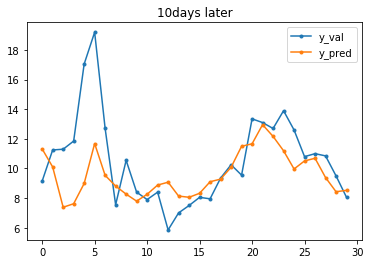

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[34]	valid_0's l1: 1.86525


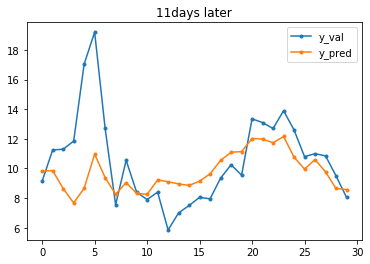

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 1.93455


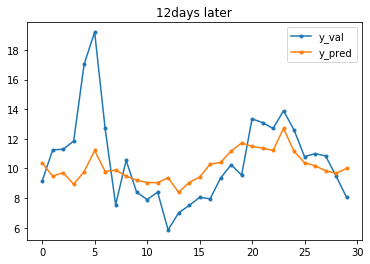

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	valid_0's l1: 1.81422


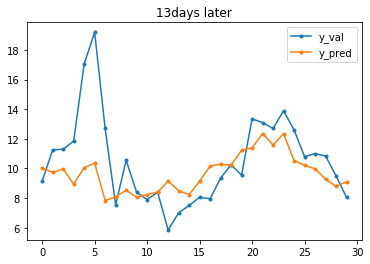

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 1.8534


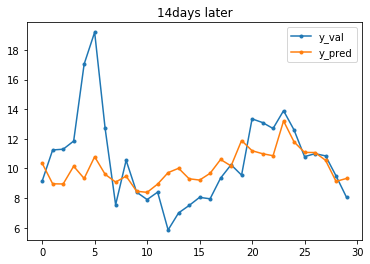

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 1.89342


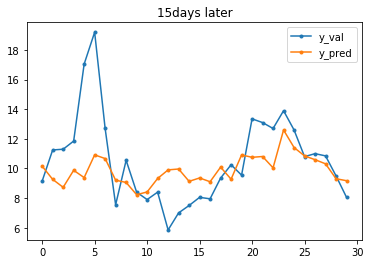

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 1.93383


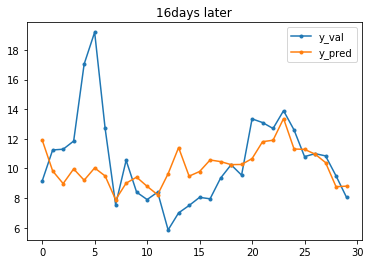

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 1.83885


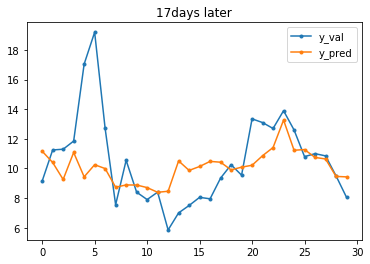

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 1.79053


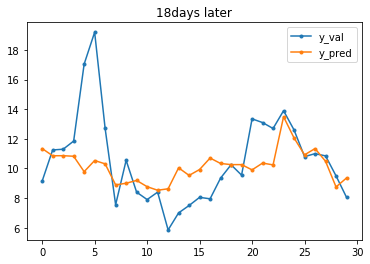

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	valid_0's l1: 1.95109


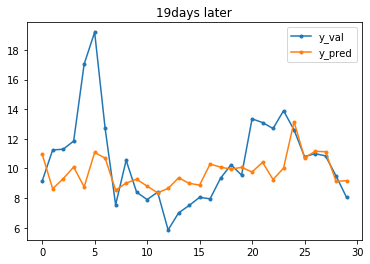

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 2.16951


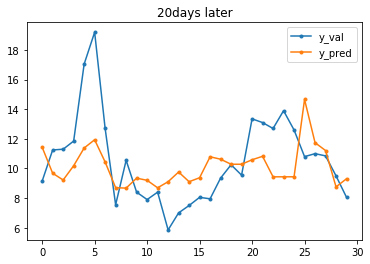

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[25]	valid_0's l1: 2.32144


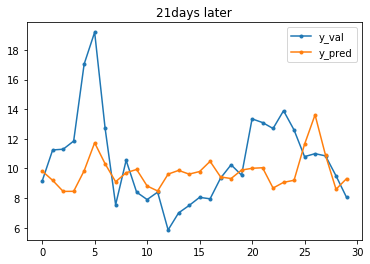

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 2.42218


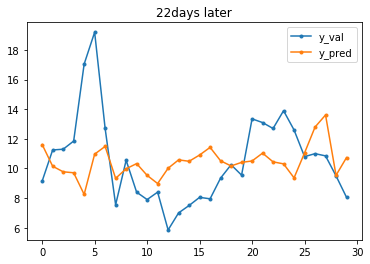

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	valid_0's l1: 2.19467


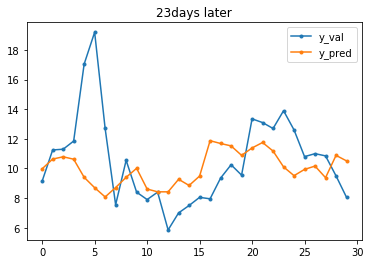

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 2.07781


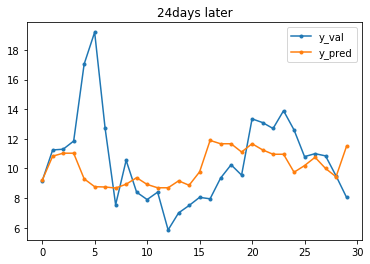

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 2.09399


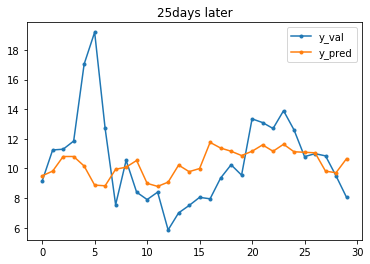

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 1.84568


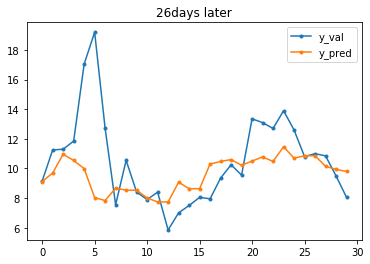

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 2.11255


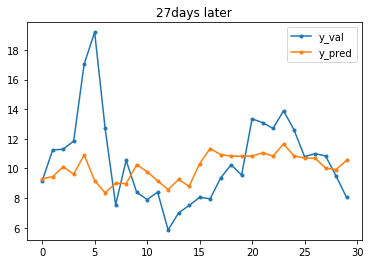

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 2.45538


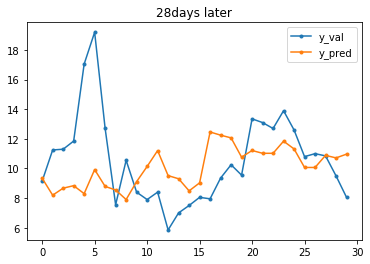

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 2.68802


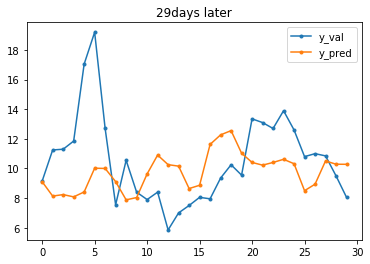

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 2.82297


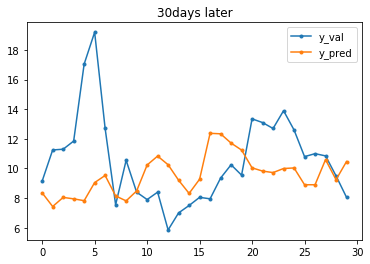

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 3.02166


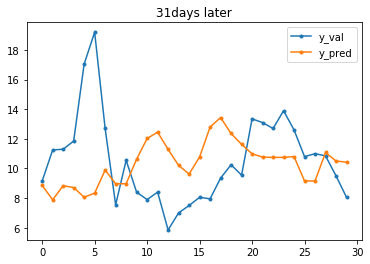

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 2.8033


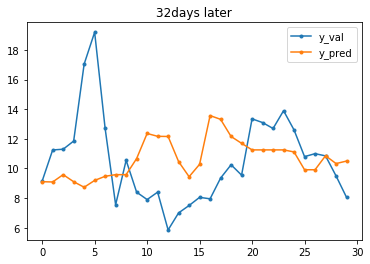

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 3.01264


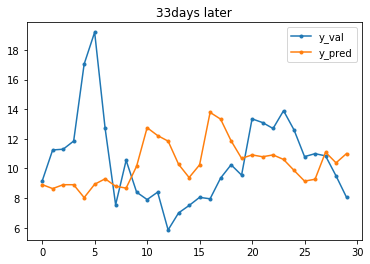

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 3.07068


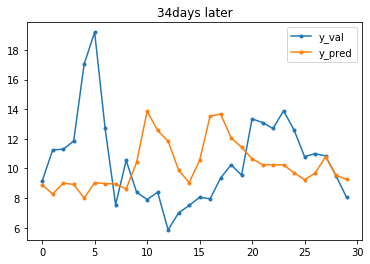

In [35]:
y_columns = ['temp_max']
temp_max_models = {}

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)

    temp_max_models[future] = create_model(d_train, d_val)
    print('==========================================================================')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 1.47053


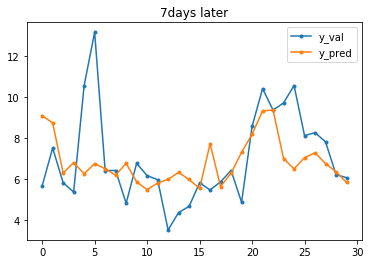

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 1.5253


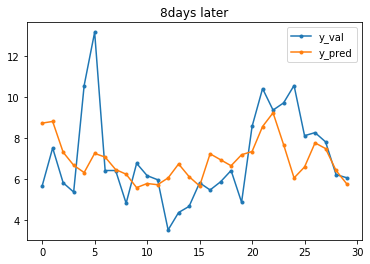

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	valid_0's l1: 1.59093


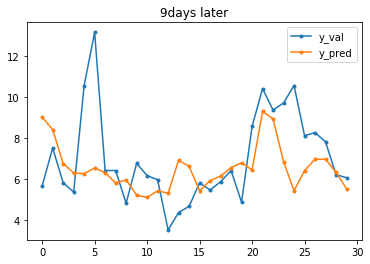

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	valid_0's l1: 1.43702


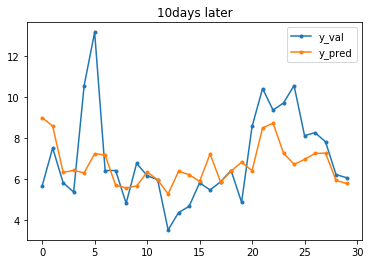

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 1.4787


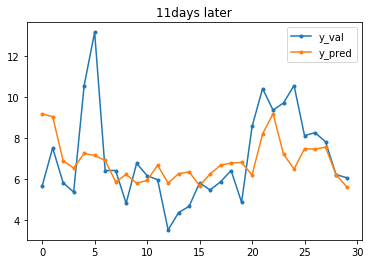

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.56254


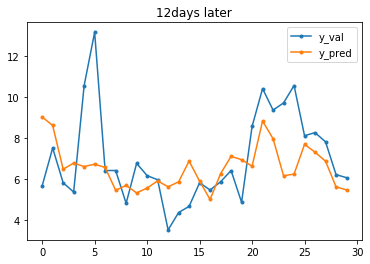

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 1.61429


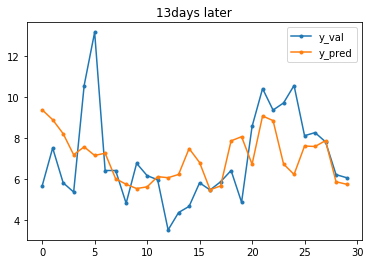

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.45637


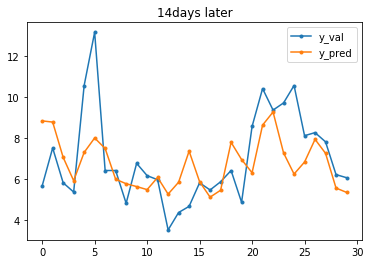

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 1.53121


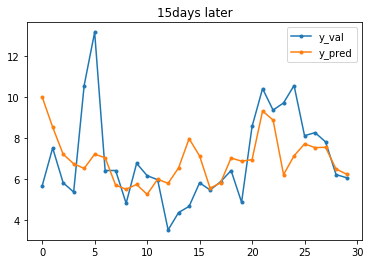

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 1.53729


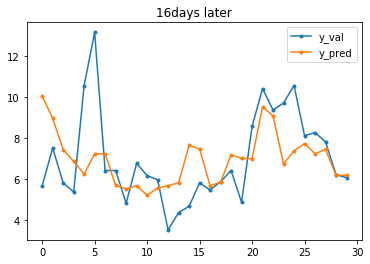

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 1.58218


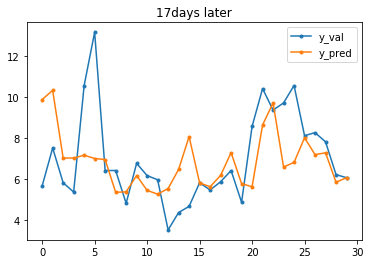

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 1.44675


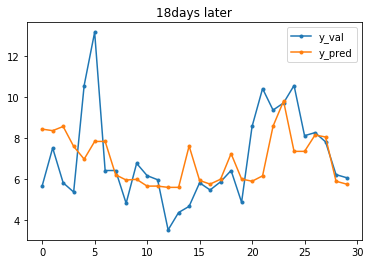

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15]	valid_0's l1: 1.47976


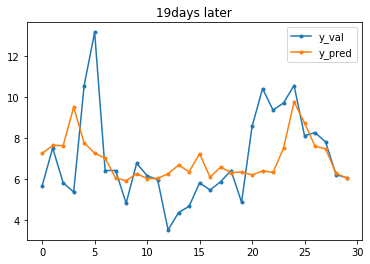

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 1.57139


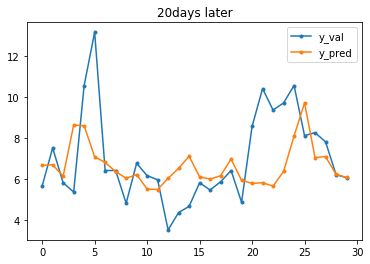

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 1.56812


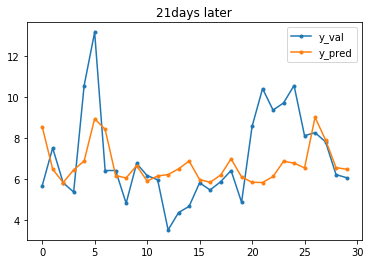

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 1.66028


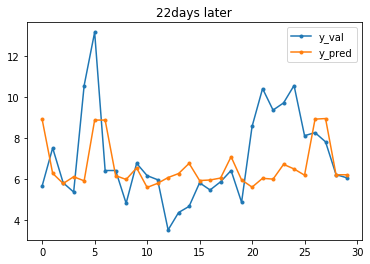

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 1.71645


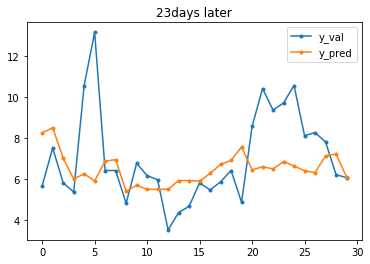

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15]	valid_0's l1: 1.60148


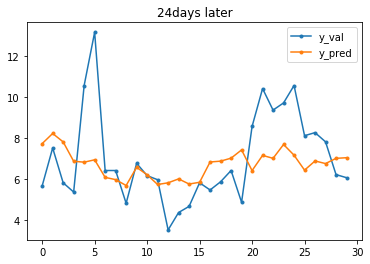

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15]	valid_0's l1: 1.60958


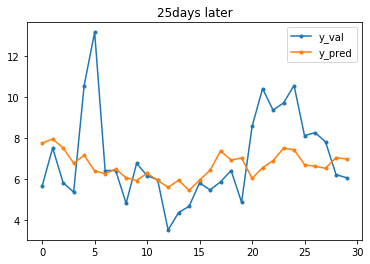

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15]	valid_0's l1: 1.5605


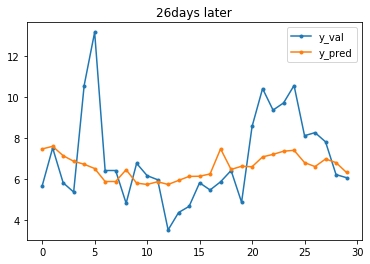

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 1.66566


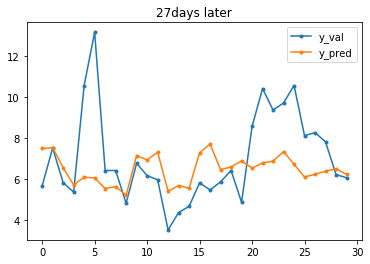

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.80674


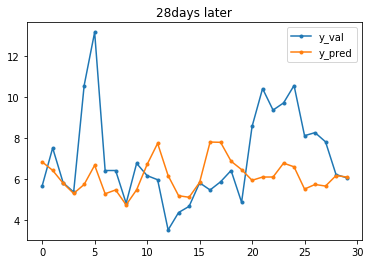

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 2.08531


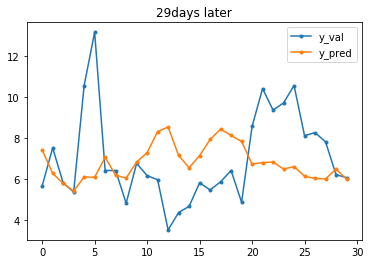

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 2.10384


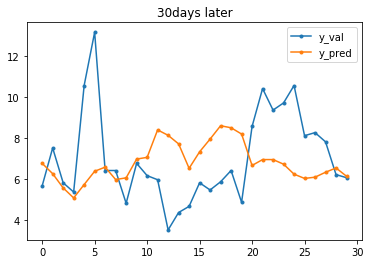

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 1.97741


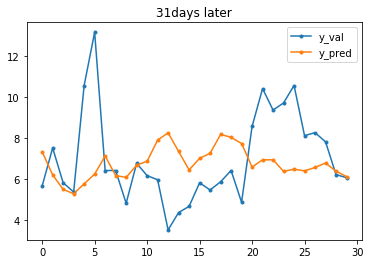

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 2.00502


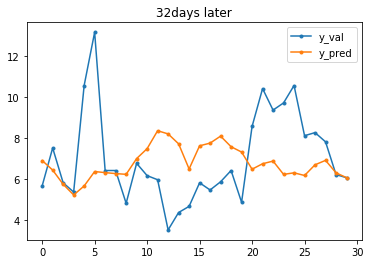

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15]	valid_0's l1: 1.80861


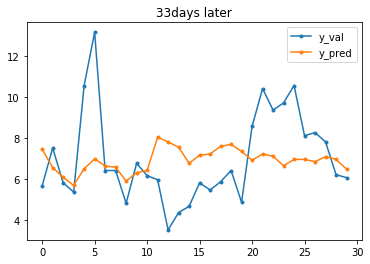

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 1.90365


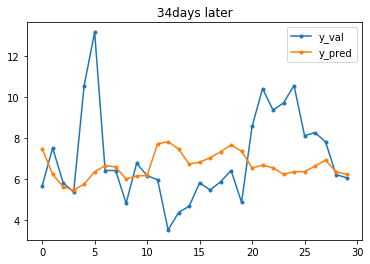

In [36]:
y_columns = ['temp_min']
temp_min_models = {}

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)

    temp_min_models[future] = create_model(d_train, d_val)
    print('==========================================================================')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 1.60179


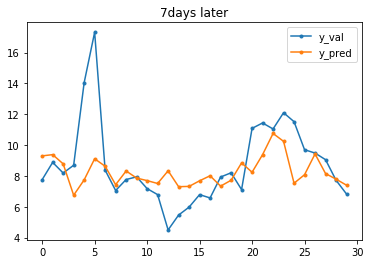

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	valid_0's l1: 1.69848


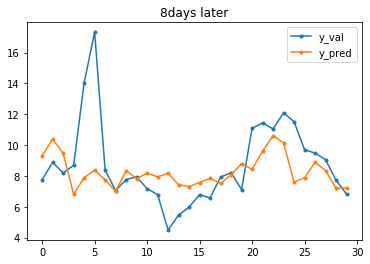

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 1.59764


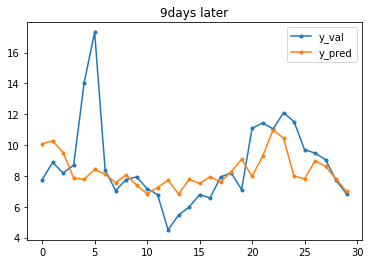

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	valid_0's l1: 1.68967


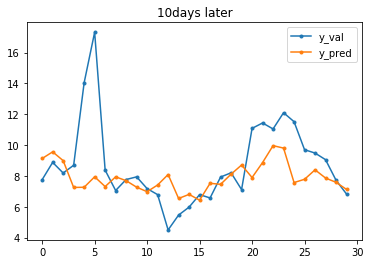

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	valid_0's l1: 1.55054


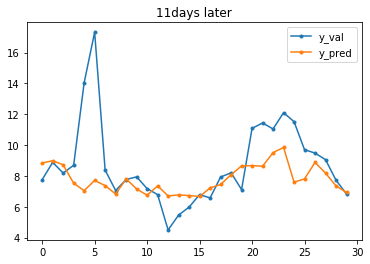

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 1.60008


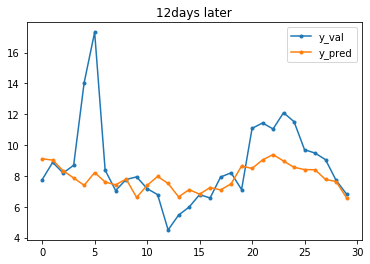

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 1.57431


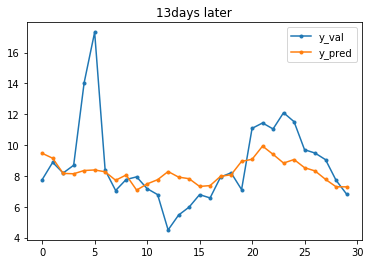

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.60729


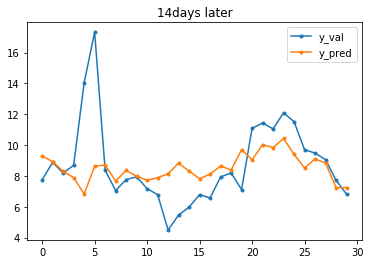

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 1.61619


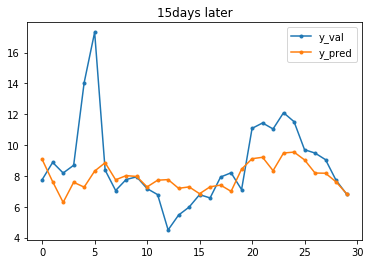

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.49885


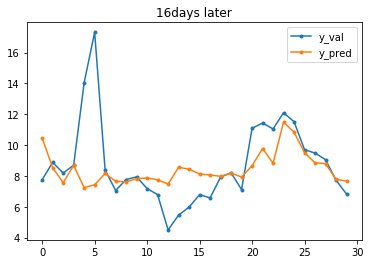

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's l1: 1.53615


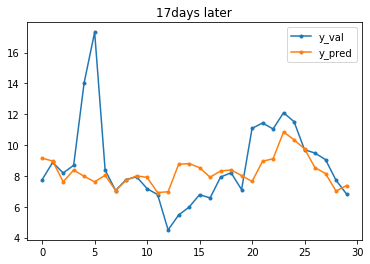

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.54932


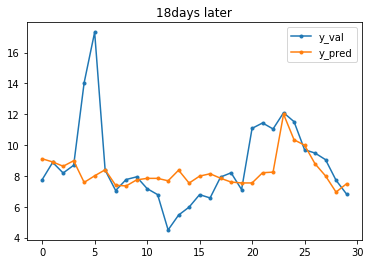

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	valid_0's l1: 1.59358


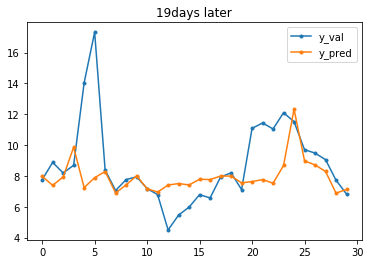

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[20]	valid_0's l1: 1.83764


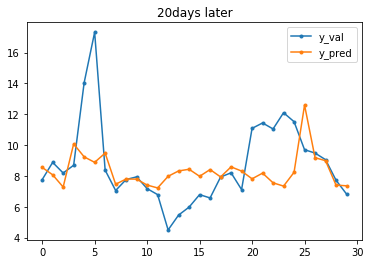

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's l1: 1.80739


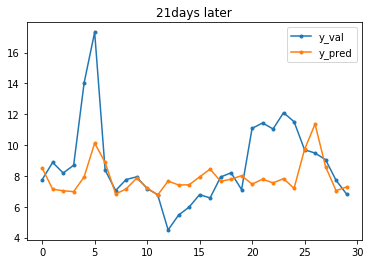

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.96153


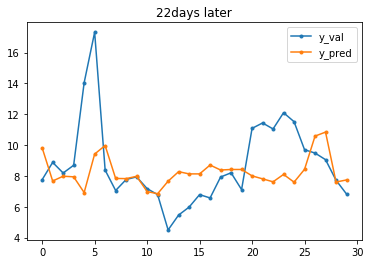

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 1.78208


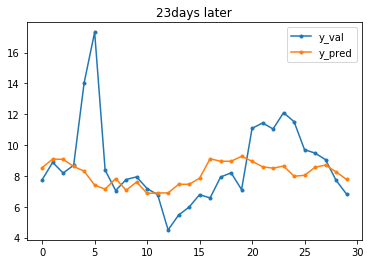

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 1.74605


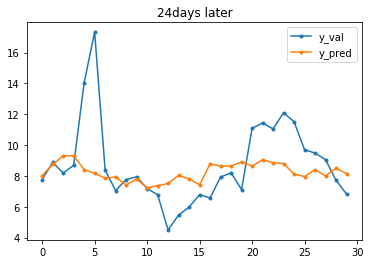

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 1.76778


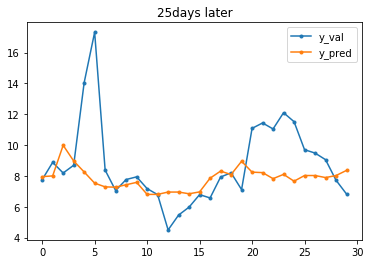

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 1.7036


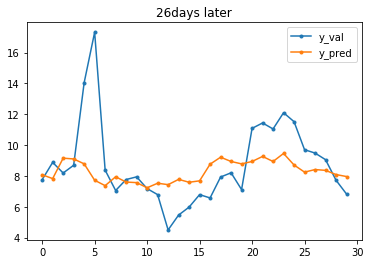

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 1.72652


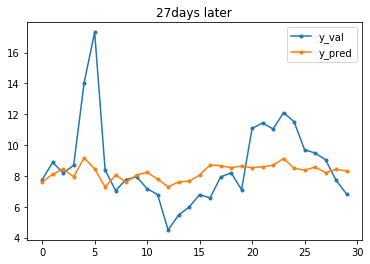

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 1.98829


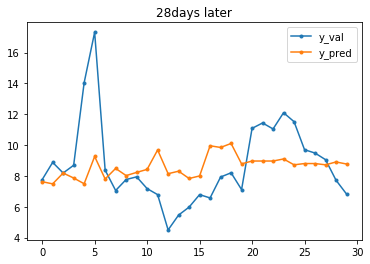

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[19]	valid_0's l1: 2.34598


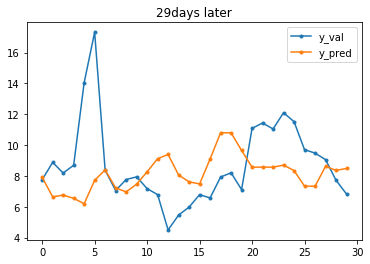

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[17]	valid_0's l1: 2.36653


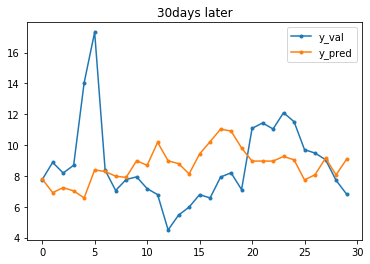

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's l1: 2.1371


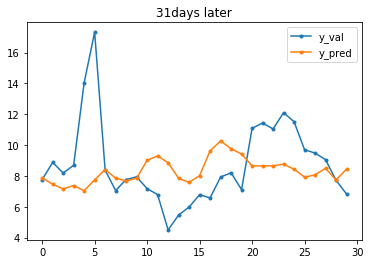

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 2.41721


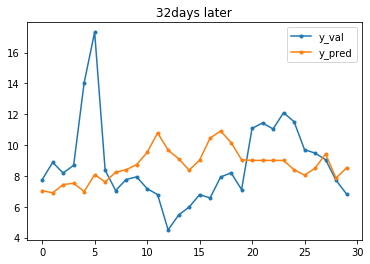

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 2.2107


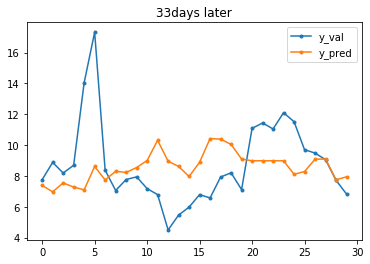

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	valid_0's l1: 2.10323


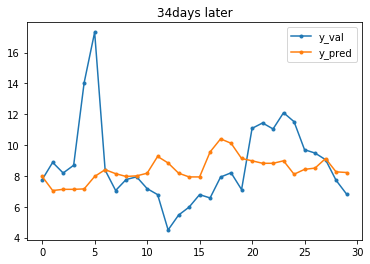

In [37]:
y_columns = ['temp_mean']
temp_mean_models = {}

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)

    temp_mean_models[future] = create_model(d_train, d_val)
    print('==========================================================================')

In [38]:
x_test = np.array(target.loc[700:, ['year', 'month', 'day', 'dayofweek', 'supply', 'temp_max', 'temp_min', 'temp_mean']])
x_test = x_test.reshape(1,-1)

In [39]:
supply_result=[]
for future in range(7, 35):
    supply_result.append(supply_models[future].predict(x_test))
supply_result = np.array(supply_result).reshape(-1)

In [40]:
x_test = np.array(target.loc[700:, ['year', 'month', 'day', 'temp_max', 'temp_min', 'temp_mean']])
x_test = x_test.reshape(1,-1)

In [41]:
temp_max_result=[]
for future in range(7, 35):
    temp_max_result.append(temp_max_models[future].predict(x_test))
temp_max_result = np.array(temp_max_result).reshape(-1)

In [42]:
temp_min_result=[]
for future in range(7, 35):
    temp_min_result.append(temp_min_models[future].predict(x_test))
temp_min_result = np.array(temp_min_result).reshape(-1)

In [43]:
temp_mean_result=[]
for future in range(7, 35):
    temp_mean_result.append(temp_mean_models[future].predict(x_test))
temp_mean_result = np.array(temp_mean_result).reshape(-1)

In [44]:
submission = pd.read_csv('data/sample_submission.csv')
submission_bottom_half = submission.loc[28:,:]
submission = submission.loc[:27, :]
test = submission.copy()
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['dayofweek'] = test['date'].dt.dayofweek
test['supply'] = np.array(supply_result).reshape(-1)
test['temp_max'] = np.array(temp_max_result).reshape(-1)
test['temp_min'] = np.array(temp_min_result).reshape(-1)
test['temp_mean'] = np.array(temp_mean_result).reshape(-1)
test.head()

date  smp_max  smp_min  smp_mean     supply  year  month  day  \
0 2020-02-07        0        0         0  82.496569  2020      2    7   
1 2020-02-08        0        0         0  79.046389  2020      2    8   
2 2020-02-09        0        0         0  79.981998  2020      2    9   
3 2020-02-10        0        0         0  80.963087  2020      2   10   
4 2020-02-11        0        0         0  77.377770  2020      2   11   

   dayofweek   temp_max  temp_min  temp_mean  
0          4  11.859904  7.276386   9.018317  
1          5  11.207859  6.592857   9.426814  
2          6  10.421841  6.343279   8.864638  
3          0  10.041606  6.361722   8.265338  
4          1  10.551647  7.068595   8.246111

In [45]:
def create_model(x_data, y_data, k=5):
    models = []
    
    k_fold = KFold(n_splits=k, shuffle=True, random_state=77)
    
    for train_idx, val_idx in k_fold.split(x_data):
        x_train, y_train = x_data.iloc[train_idx], y_data[train_idx]
        x_val, y_val = x_data.iloc[val_idx], y_data[val_idx]
    
        d_train = lgb.Dataset(x_train, y_train)
        d_val = lgb.Dataset(x_val, y_val)

        params = {
            'metric': 'mse',
            'seed':777
            }

        model = lgb.train(params, d_train, 1000, d_val, verbose_eval=1000, early_stopping_rounds=100)
        
        plt.rcParams['figure.figsize'] = [12, 4]
        plt.plot(np.array(y_val), '.-', label='y_val')
        plt.plot(model.predict(x_val), '.-', label='y_pred')
        plt.legend()
        plt.show()
        models.append(model)

    return models

train column :  smp_min
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[39]	valid_0's l2: 448.46


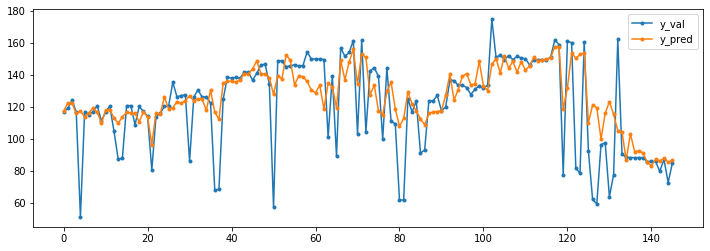

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	valid_0's l2: 236.052


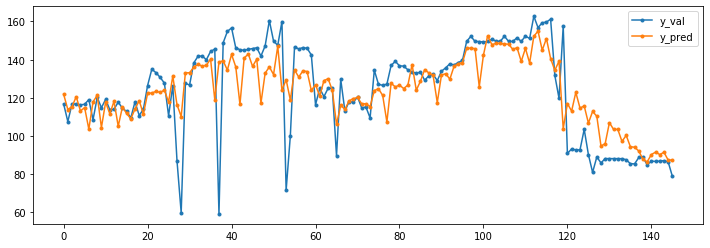

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's l2: 264.42


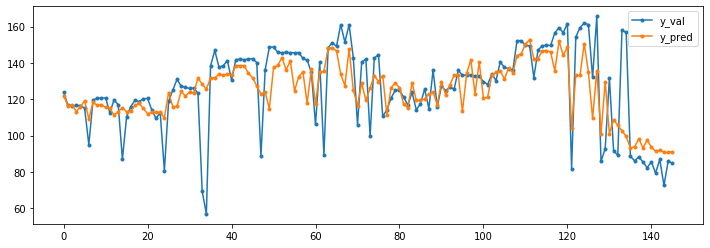

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	valid_0's l2: 184.325


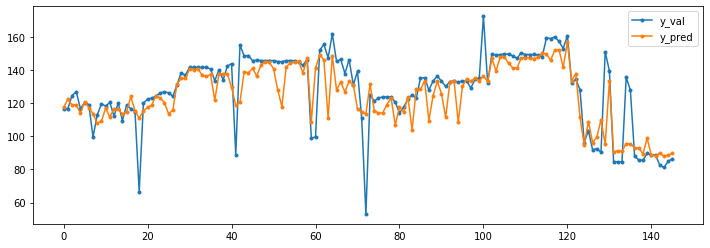

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 140.147


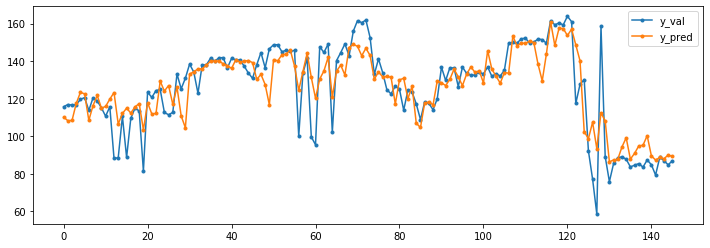

train column :  smp_max
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	valid_0's l2: 401.185


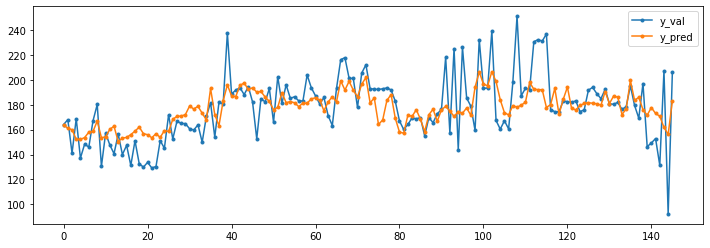

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[31]	valid_0's l2: 306.148


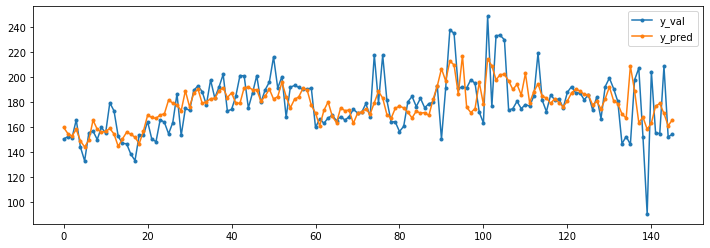

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	valid_0's l2: 242.685


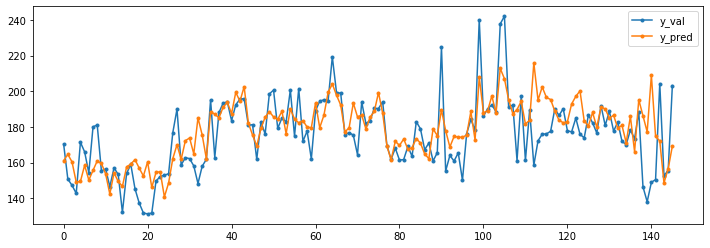

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 1478.19


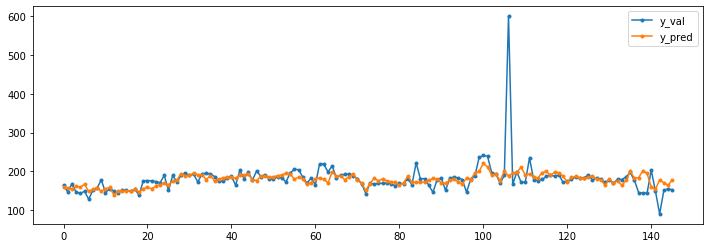

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	valid_0's l2: 747.133


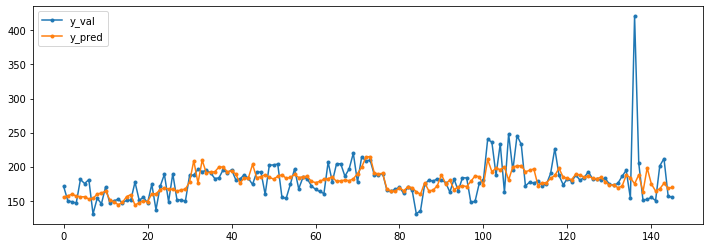

train column :  smp_mean
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[146]	valid_0's l2: 65.8951


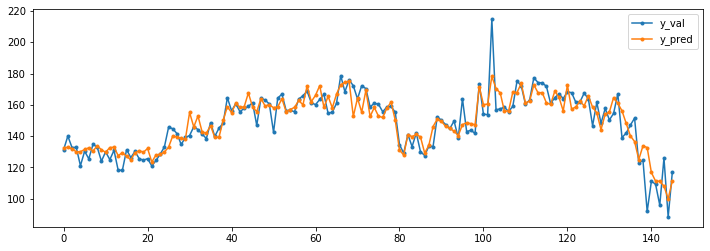

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	valid_0's l2: 68.6491


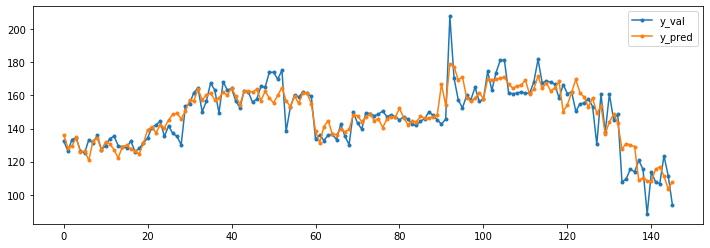

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	valid_0's l2: 60.5549


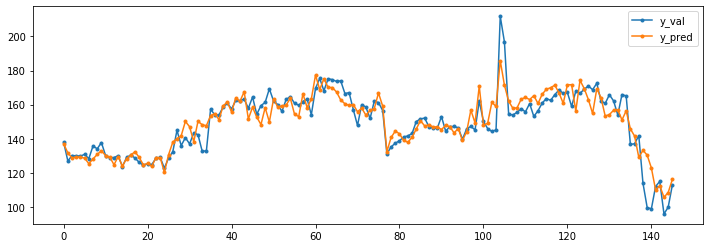

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[118]	valid_0's l2: 86.0354


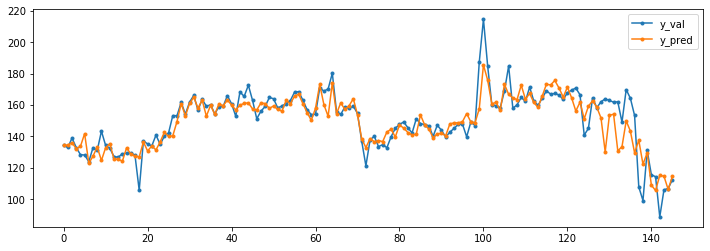

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[130]	valid_0's l2: 63.586


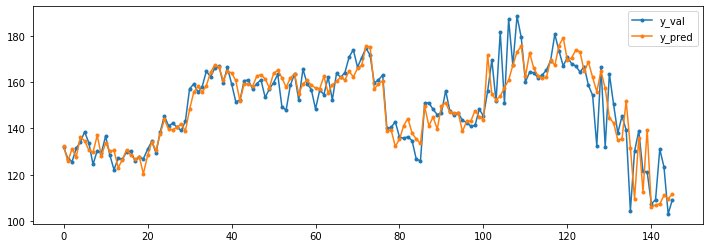

In [46]:
x_train = target.loc[:, ['supply', 'year', 'month', 'day', 'dayofweek', 'temp_max', 'temp_min', 'temp_mean']]
y_train = target.loc[:, ['smp_min', 'smp_max', 'smp_mean' ]]

smp_models = {}
for label in y_train.columns:
    print('train column : ', label)
    smp_models[label] = create_model(x_train, y_train[label])
    print('==========================================================================')

In [47]:
x_test = test.loc[:,['supply', 'year', 'month', 'day', 'dayofweek', 'temp_max', 'temp_min', 'temp_mean']]
for label in ['smp_min', 'smp_max', 'smp_mean']:
    preds = []
    for i in range(5):
        preds.append(smp_models[label][i].predict(x_test))
    pred = sum(preds)/len(preds)
    test[label] = pred

In [48]:
submission.loc[:, ['smp_min', 'smp_max', 'smp_mean', 'supply']] = test.loc[:,['smp_min', 'smp_max', 'smp_mean', 'supply']]
submission = pd.concat([submission, submission_bottom_half], axis = 0)
submission

date     smp_max    smp_min    smp_mean     supply
0   2020-02-07  165.493193  88.709063  109.913042  82.496569
1   2020-02-08  162.320987  88.971404  111.244159  79.046389
2   2020-02-09  160.520007  88.570945  111.018134  79.981998
3   2020-02-10  163.032641  89.408701  108.968641  80.963087
4   2020-02-11  160.857398  87.068646  103.995566  77.377770
5   2020-02-12  166.862852  88.036351  107.140419  77.728650
6   2020-02-13  167.196096  89.482493  110.955854  81.920374
7   2020-02-14  164.297739  89.573868  109.946148  79.702642
8   2020-02-15  164.463899  89.746163  108.988141  81.617514
9   2020-02-16  159.168406  87.676457  103.536302  77.173154
10  2020-02-17  163.831395  87.382101  107.615472  76.908359
11  2020-02-18  167.277181  87.402340  109.725411  77.737701
12  2020-02-19  169.076884  88.705660  111.944422  78.348053
13  2020-02-20  162.192448  86.466703  108.859525  76.588477
14  2020-02-21  157.530900  86.444949  106.413118  76.220508
15  2020-02-22  165.181776  88.465115  111.767964  80.086669
16  2020-02-23  165.535859  88.304963  109.799324  80.525564
17  2020-02-24  168.358872  88.486365  111.976657  80.154525
18  2020-02-25  168.147948  88.402366  111.049130  79.076656
19  2020-02-26  168.051033  88.403171  108.773814  78.895614
20  2020-02-27  168.336985  88.294672  111.416768  79.157527
21  2020-02-28  167.341008  87.878078  108.721432  78.145359
22  2020-02-29  164.520961  88.293552  108.302005  78.614184
23  2020-03-01  155.872963  89.152053  109.806288  75.816287
24  2020-03-02  172.238010  90.679501  111.291106  80.519092
25  2020-03-03  173.294066  91.232346  110.490641  80.822140
26  2020-03-04  173.671704  91.241938  112.503449  79.217656
27  2020-03-05  173.853317  91.281450  113.840123  79.932619
28  2020-05-25    0.000000   0.000000    0.000000   0.000000
29  2020-05-26    0.000000   0.000000    0.000000   0.000000
30  2020-05-27    0.000000   0.000000    0.000000   0.000000
31  2020-05-28    0.000000   0.000000    0.000000   0.000000
32  2020-05-29    0.000000   0.000000    0.000000   0.000000
33  2020-05-30    0.000000   0.000000    0.000000   0.000000
34  2020-05-31    0.000000   0.000000    0.000000   0.000000
35  2020-06-01    0.000000   0.000000    0.000000   0.000000
36  2020-06-02    0.000000   0.000000    0.000000   0.000000
37  2020-06-03    0.000000   0.000000    0.000000   0.000000
38  2020-06-04    0.000000   0.000000    0.000000   0.000000
39  2020-06-05    0.000000   0.000000    0.000000   0.000000
40  2020-06-06    0.000000   0.000000    0.000000   0.000000
41  2020-06-07    0.000000   0.000000    0.000000   0.000000
42  2020-06-08    0.000000   0.000000    0.000000   0.000000
43  2020-06-09    0.000000   0.000000    0.000000   0.000000
44  2020-06-10    0.000000   0.000000    0.000000   0.000000
45  2020-06-11    0.000000   0.000000    0.000000   0.000000
46  2020-06-12    0.000000   0.000000    0.000000   0.000000
47  2020-06-13    0.000000   0.000000    0.000000   0.000000
48  2020-06-14    0.000000   0.000000    0.000000   0.000000
49  2020-06-15    0.000000   0.000000    0.000000   0.000000
50  2020-06-16    0.000000   0.000000    0.000000   0.000000
51  2020-06-17    0.000000   0.000000    0.000000   0.000000
52  2020-06-18    0.000000   0.000000    0.000000   0.000000
53  2020-06-19    0.000000   0.000000    0.000000   0.000000
54  2020-06-20    0.000000   0.000000    0.000000   0.000000
55  2020-06-21    0.000000   0.000000    0.000000   0.000000

In [49]:
submission.to_csv('Dacon_baseline.csv', index=False)